In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Consulta datos totales por día

con=sqlite3.connect('COVID_CV_GVA.db')

data=pd.read_sql_query("""
                        SELECT fecha,SUM(acumulados_caso) AS casos_tot,SUM(acumulado_fallecidos) AS fallecidos_tot
                        FROM COVID_CV_GVA
                        GROUP BY fecha
                        """,con)

# data

# # Pasamos la fecha como indice y lo pasamos a formato fecha
data=data.set_index("fecha")
data.index = pd.to_datetime(data.index)

# # data

# # # Calculamos casos y fallecidos cada 24h
data['casos_24h']=data["casos_tot"].diff()
data['fallecidos_24h']=data["fallecidos_tot"].diff()

# # # Copiamos la tabla antes de rellenar los huecos para usarla posteriormente.
temp=data.copy()

# # # Rellenamos las fechas que faltan y volvemos a poner la fecha como columna en vez de indice.
data=data.resample("D").asfreq()

data=data.reset_index()

data.head(10)

fecha  casos_tot  fallecidos_tot  casos_24h  fallecidos_24h
0 2020-04-12     9058.0           876.0        NaN             NaN
1 2020-04-13     9208.0           907.0      150.0            31.0
2 2020-04-14     9311.0           945.0      103.0            38.0
3 2020-04-15     9562.0           972.0      251.0            27.0
4 2020-04-16     9829.0           999.0      267.0            27.0
5 2020-04-17    10102.0          1042.0      273.0            43.0
6 2020-04-18    10247.0          1065.0      145.0            23.0
7 2020-04-19    10332.0          1084.0       85.0            19.0
8 2020-04-20    10396.0          1094.0       64.0            10.0
9 2020-04-21    10572.0          1112.0      176.0            18.0

In [3]:
# Calculamos la indicencia a 14 dias

IA_14d=[None]*13

for i in data.index[13:]:
    if (not np.isnan(data["casos_24h"].iloc[i])):
        IA_14d.append("{:.2f}".format(data["casos_24h"].iloc[i+1-14:i+1].sum()*1e5/4.975e6))
    else:
        IA_14d.append(None)

IA_14d=np.array(IA_14d,dtype=float)

data["IA_14d"]=IA_14d

# data.tail(10)

In [4]:
# Calculamos la indicencia a 7 días

IA_7d=[None]*6

for i in data.index[6:]:
    if (not np.isnan(data["casos_24h"].iloc[i])):
        IA_7d.append("{:.2f}".format(data["casos_24h"].iloc[i+1-7:i+1].sum()*1e5/4.975e6))
    else:
        IA_7d.append(None)

IA_7d=np.array(IA_7d,dtype=float)

data["IA_7d"]=IA_7d

# data

In [5]:
# Creamos tablas con una submuestra de la tabla original para luego representar

data=data.set_index("fecha")

# Datos 2021
data_2021=data.copy()
data_2021=data["2021-09-15":]

In [6]:
# Sumamos los datos semanalmente
data_sem=data.resample('W').sum()
data_sem.drop("casos_tot",axis=1,inplace=True)
data_sem.drop("fallecidos_tot",axis=1,inplace=True)
data_sem.drop("IA_14d",axis=1,inplace=True)
data_sem.drop("IA_7d",axis=1,inplace=True)
# data_sem

In [7]:
# Creamos una tabla nueva sin valores NULL para el ajuste
temp_ajus=data.copy()
temp_ajus=temp_ajus.dropna(how='any',axis=0)

In [8]:
# Guardamos la tabla en un csv
data.to_csv(path_or_buf="datos_todo_junto.csv")
data_sem.to_csv(path_or_buf="datos_semanales.csv")

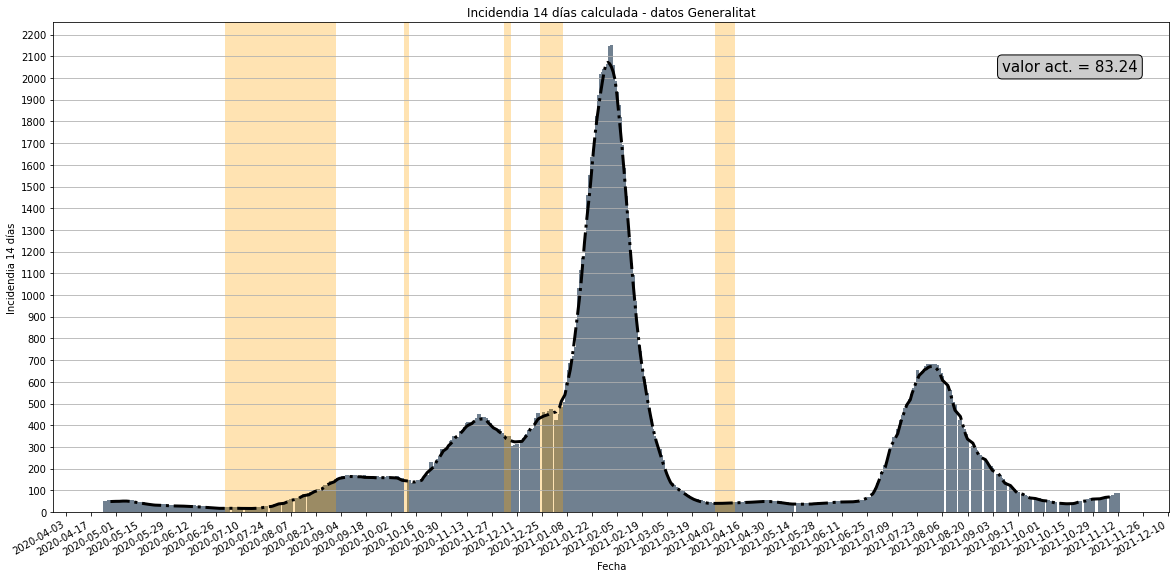

In [48]:
# Parámetros que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

# Representamos la incidencia a 14 días

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data.index,data["IA_14d"],width=1,fill=False,linewidth=2,ec="slategray")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp_ajus["IA_14d"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
# ax.axvline(x="2020-05-18", ymin=0, ymax=1,color="red")
# ax.text("2020-05-19",2100,"Fase 1",fontsize=15)

# ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
# ax.text("2020-06-02",1900,"Fase 2",fontsize=15)

# ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
# ax.text("2020-06-16",2100,"Fase 3",fontsize=15)

# ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
# ax.text("2020-06-22",1900,"Nueva normalidad",fontsize=15)

# ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
# ax.text("2020-10-29",1500,"Cierre perimetral comunidad",fontsize=15,horizontalalignment="right")

# ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
# ax.text("2021-01-20",2100,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

# ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
# ax.text("2021-02-02",2150,"Cierre perimetral",fontsize=15)
# ax.text("2021-02-04",2050,"limit. social",fontsize=15)

# ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
# ax.text("2021-03-02",2000,"Abre terrazas -",fontsize=15)
# ax.text("2021-03-02",1900,"4 pers. exterior",fontsize=15)

# ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
# ax.text("2021-03-16",1700,"Interior 30% -",fontsize=15)
# ax.text("2021-03-16",1600,"gimnasios",fontsize=15)

# ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
# ax.text("2021-04-13",1400,"Viviendas 2 fam. -",fontsize=15)
# ax.text("2021-04-13",1300,"6 pers. inter. y exter.",fontsize=15)

# ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
# ax.text("2021-04-27",1100,"host. - comer. 22h",fontsize=15)
# ax.text("2021-04-27",1000,"aumento foro ocio",fontsize=15)

# ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
# ax.text("2021-05-10",2150,"fin perimetracion",fontsize=15)
# ax.text("2021-05-10",2050,"toque queda 00h- 10 pers.",fontsize=15)

# ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
# ax.text("2021-05-25",1900,"toque queda 01h",fontsize=15)

# ax.axhline(y=data["IA_14d"].iloc[-1],color="darkslategray",linestyle="--")
ax.annotate("valor act. = {:.5}".format(data["IA_14d"].iloc[-1])
                  ,xy=(0.85, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones 
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días calculada - datos Generalitat')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.grid()
ax.yaxis.set_ticks(np.arange(starty, endy, 100))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
fig.autofmt_xdate()

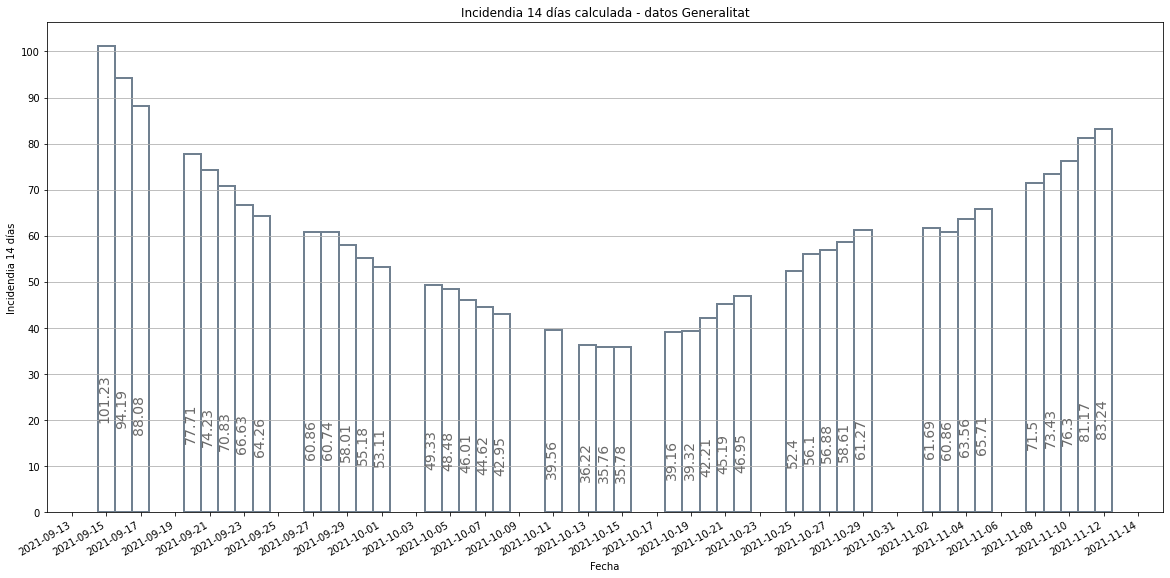

In [10]:
# Representamos la incidencia a 14 días solo de los datos de 2021

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["IA_14d"],width=1,fill=False,linewidth=2,ec="slategray")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días calculada - datos Generalitat')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.set_ylim((0,endy))
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
fig.autofmt_xdate()

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 20:
        ax.text(i.get_x(), i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 20:
            ax.text(i.get_x(), i.get_height()+2, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

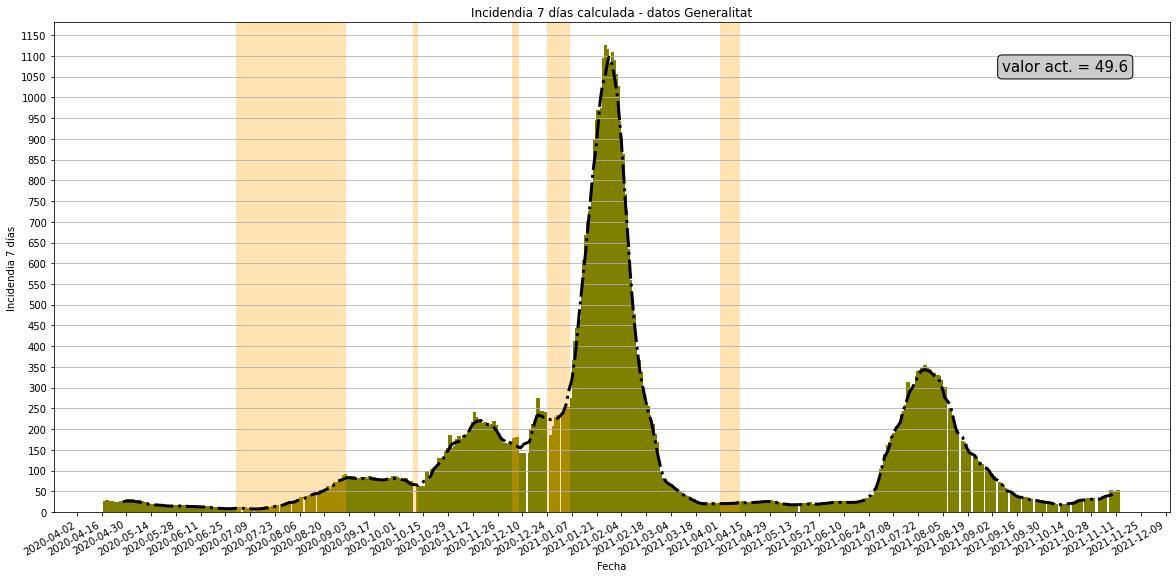

In [49]:
# Representamos la incidencia a 7 días

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data.index,data["IA_7d"],width=1,fill=False,linewidth=2,ec="olive")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp_ajus["IA_7d"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
# ax.axvline(x="2020-05-18", ymin=0, ymax=1,color="red")
# ax.text("2020-05-19",1100,"Fase 1",fontsize=15)

# ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
# ax.text("2020-06-02",1000,"Fase 2",fontsize=15)

# ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
# ax.text("2020-06-16",1100,"Fase 3",fontsize=15)

# ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
# ax.text("2020-06-22",1000,"Nueva normalidad",fontsize=15)

# ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
# ax.text("2020-10-29",750,"Cierre perimetral comunidad",fontsize=15,horizontalalignment="right")

# ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
# ax.text("2021-01-20",1100,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

# ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
# ax.text("2021-02-02",1100,"Cierre perimetral",fontsize=15)
# ax.text("2021-02-04",1050,"limit. social",fontsize=15)

# ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
# ax.text("2021-03-02",1000,"Abre terrazas -",fontsize=15)
# ax.text("2021-03-02",950,"4 pers. exterior",fontsize=15)

# ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
# ax.text("2021-03-16",850,"Interior 30% -",fontsize=15)
# ax.text("2021-03-16",800,"gimnasios",fontsize=15)

# ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
# ax.text("2021-04-13",700,"Viviendas 2 fam. -",fontsize=15)
# ax.text("2021-04-13",650,"6 pers. inter. y exter.",fontsize=15)

# ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
# ax.text("2021-04-27",550,"host. - comer. 22h",fontsize=15)
# ax.text("2021-04-27",500,"aumento foro ocio",fontsize=15)

# ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
# ax.text("2021-05-10",1100,"fin perimetracion",fontsize=15)
# ax.text("2021-05-10",1050,"toque queda 00h - 10 pers.",fontsize=15)

# ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
# ax.text("2021-05-25",950,"toque queda 01h",fontsize=15)

# ax.axhline(y=data["IA_7d"].iloc[-1],color="darkslategray",linestyle="--")
ax.annotate("valor act. = {:.3}".format(data["IA_7d"].iloc[-1])
                  ,xy=(0.85, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones 
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días calculada - datos Generalitat')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
#ax.set_xlim((data["fecha"].iloc[0],data["fecha"].iloc[-1]))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
fig.autofmt_xdate()

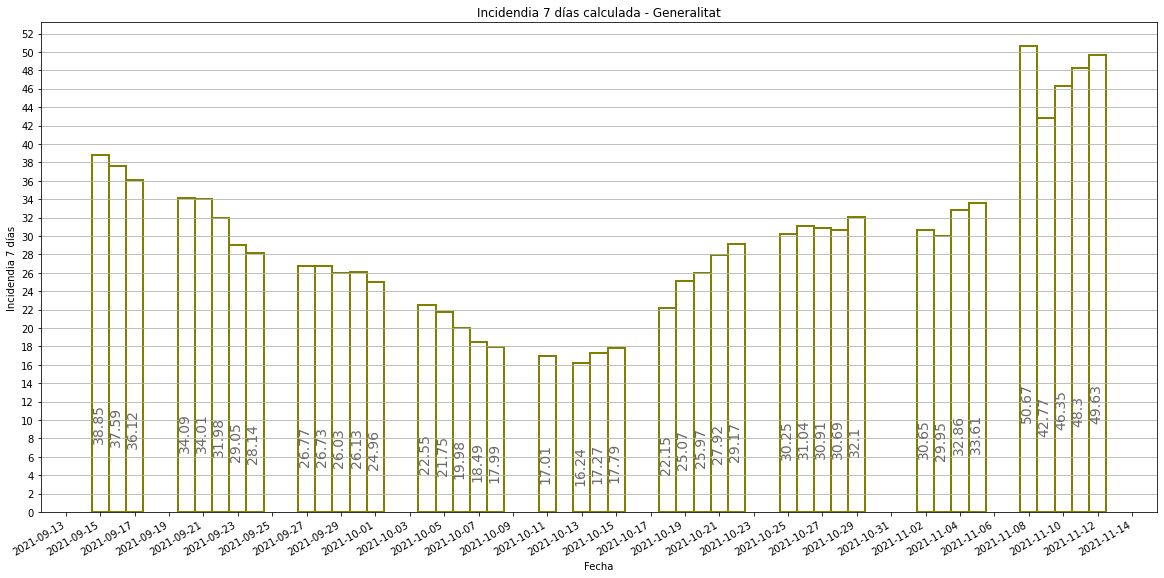

In [12]:
# Representamos la incidencia a 7 días solo de los datos de 2021

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["IA_7d"],width=1,fill=False,linewidth=2,ec="olive")

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días calculada - Generalitat')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 2))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
fig.autofmt_xdate()

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 10:
        ax.text(i.get_x(), i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 10:
            ax.text(i.get_x(), i.get_height()+2, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

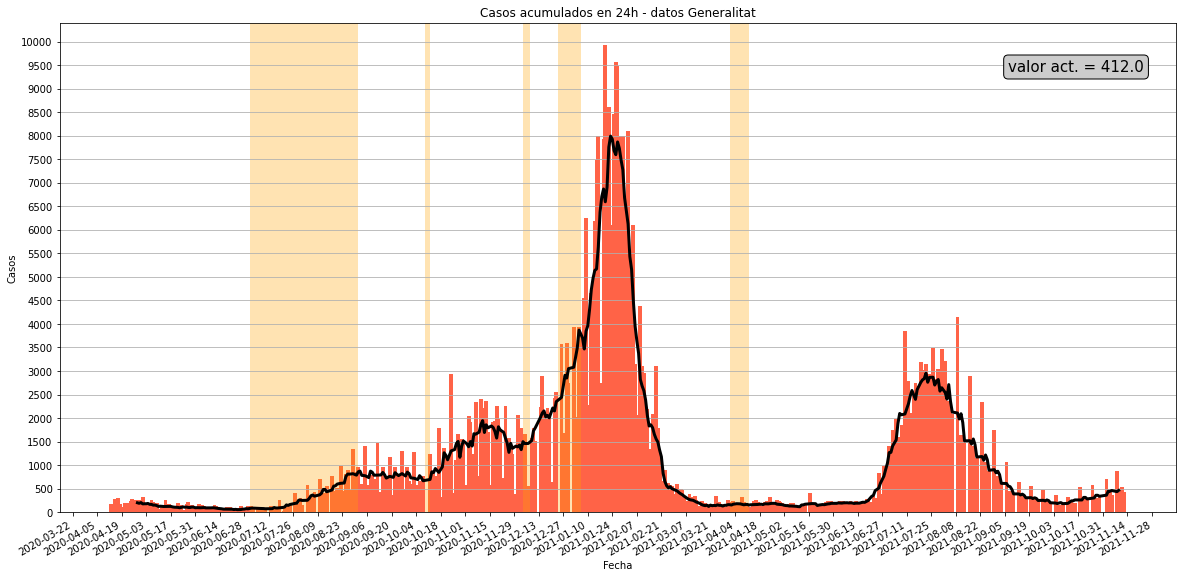

In [50]:
# Representamos los casos acumulados en 24h
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data.index,data["casos_24h"],width=1,fill=False,linewidth=2,ec="tomato")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp_ajus["casos_24h"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-",linewidth=3)

# Linea horizontal con el último valor calculado de la tendencia de los datos
# ax.axhline(y=decompose.trend.iloc[-4],color="darkslategray",linestyle="--")

# Dibujamos líneas verticales con cada cambio de las restricciones
# ax.axvline(x="2020-05-18", ymin=0, ymax=1,color="red")
# ax.text("2020-05-19",9500,"Fase 1",fontsize=15)

# ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
# ax.text("2020-06-02",8500,"Fase 2",fontsize=15)

# ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
# ax.text("2020-06-16",9500,"Fase 3",fontsize=15)

# ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
# ax.text("2020-06-22",8500,"Nueva normalidad",fontsize=15)

# ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
# ax.text("2020-10-29",6500,"Cierre perimetral comunidad",fontsize=15,horizontalalignment="right")

# ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
# ax.text("2021-01-20",9500,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

# ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
# ax.text("2021-02-02",9500,"Cierre perimetral",fontsize=15)
# ax.text("2021-02-04",9000,"limit. social",fontsize=15)

# ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
# ax.text("2021-03-02",8500,"Abre terrazas -",fontsize=15)
# ax.text("2021-03-02",8000,"4 pers. exterior",fontsize=15)

# ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
# ax.text("2021-03-16",7000,"Interior 30% -",fontsize=15)
# ax.text("2021-03-16",6500,"gimnasios",fontsize=15)

# ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
# ax.text("2021-04-13",5500,"Viviendas 2 fam. -",fontsize=15)
# ax.text("2021-04-13",5000,"6 pers. inter. y exter.",fontsize=15)

# ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
# ax.text("2021-04-27",4000,"host. - comer. 22h",fontsize=15)
# ax.text("2021-04-27",3500,"aumento foro ocio",fontsize=15)

# ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
# ax.text("2021-05-10",9500,"fin perimetracion",fontsize=15)
# ax.text("2021-05-10",9000,"toque queda 00h - 10 pers.",fontsize=15)

# ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
# ax.text("2021-05-25",8000,"toque queda 01h",fontsize=15)

ax.annotate("valor act. = {:.5}".format(data["casos_24h"].iloc[-1])
                  ,xy=(0.85, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones 
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulados en 24h - datos Generalitat')
ax.set_ylabel('Casos')
ax.set_xlabel('Fecha')


starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 500))
ax.yaxis.grid()
#ax.set_xlim((data["fecha"].iloc[0],data["fecha"].iloc[-1]))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
fig.autofmt_xdate()

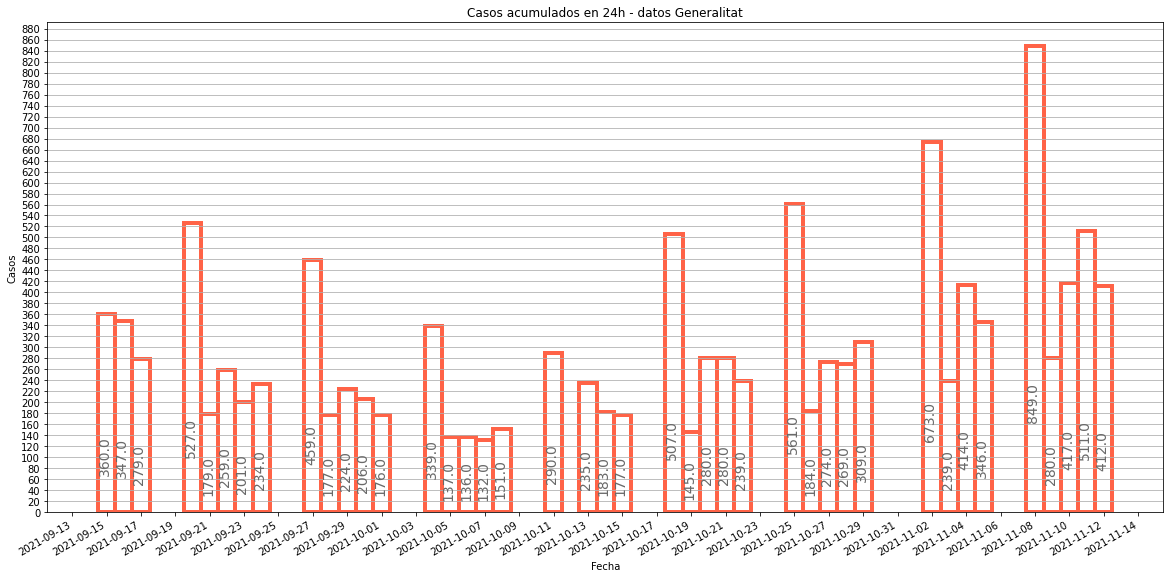

In [14]:
# Representamos los casos acumulados solo de los datos de 2021

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["casos_24h"],width=1,fill=False,linewidth=4,ec="tomato")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulados en 24h - datos Generalitat')
ax.set_ylabel('Casos')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 20))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
fig.autofmt_xdate()

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 50:
        ax.text(i.get_x(), i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 50:
            ax.text(i.get_x(), i.get_height()+10, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

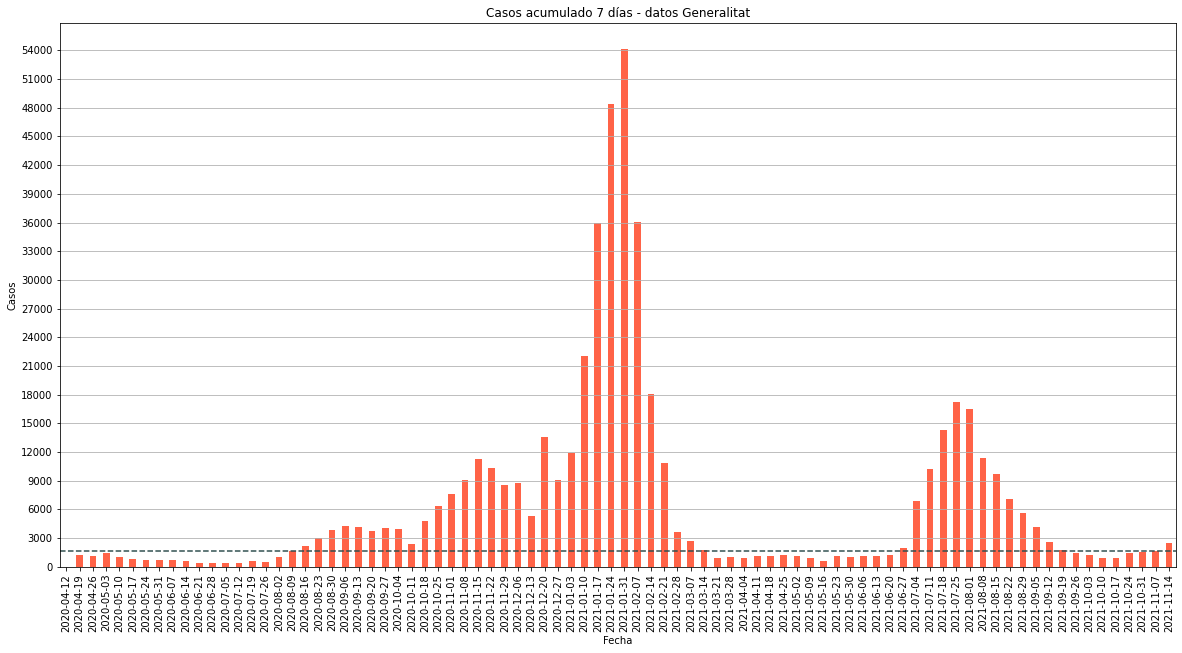

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
data_sem["casos_24h"].plot.bar(rot=90,ax=ax,color="tomato")

ax.axhline(y=data_sem["casos_24h"].iloc[-2],color="darkslategray",linestyle="--",linewidth=1.5)


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulado 7 días - datos Generalitat')
ax.set_ylabel('Casos')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.grid()
ax.yaxis.set_ticks(np.arange(starty, endy, 3000))
a=ax.set_xticklabels(data_sem.index.format(), rotation="vertical")

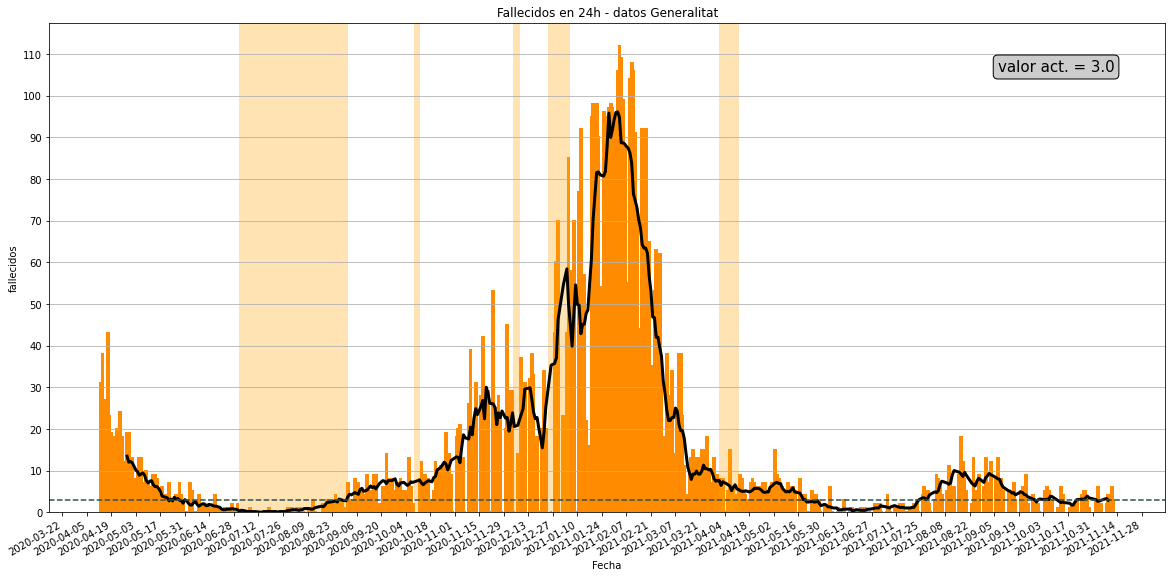

In [51]:
# Representamos los fallecidos en 24h

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data.index,data["fallecidos_24h"],width=1,fill=False,linewidth=2,ec="darkorange")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp_ajus["fallecidos_24h"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linewidth=3)

# Linea horizontal con el último valor calculado de la tendencia de los datos
ax.axhline(y=decompose.trend.iloc[-4],color="darkslategray",linestyle="--")

# Dibujamos líneas verticales con cada cambio de las restricciones
# ax.axvline(x="2020-05-18", ymin=0, ymax=1,color="red")
# ax.text("2020-05-19",110,"Fase 1",fontsize=15)

# ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
# ax.text("2020-06-02",100,"Fase 2",fontsize=15)

# ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
# ax.text("2020-06-16",110,"Fase 3",fontsize=15)

# ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
# ax.text("2020-06-22",100,"Nueva normalidad",fontsize=15)

# ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
# ax.text("2020-10-29",70,"Cierre perimetral comunidad",fontsize=15,horizontalalignment="right")

# ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
# ax.text("2021-01-20",110,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

# ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
# ax.text("2021-02-02",110,"Cierre perimetral",fontsize=15)
# ax.text("2021-02-04",105,"limit. social",fontsize=15)

# ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
# ax.text("2021-03-02",90,"Abre terrazas -",fontsize=15)
# ax.text("2021-03-02",85,"4 pers. exterior",fontsize=15)

# ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
# ax.text("2021-03-16",70,"Interior 30% -",fontsize=15)
# ax.text("2021-03-16",65,"gimnasios",fontsize=15)

# ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
# ax.text("2021-04-13",50,"Viviendas 2 fam. -",fontsize=15)
# ax.text("2021-04-13",45,"6 pers. inter. y exter.",fontsize=15)

# ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
# ax.text("2021-04-27",30,"host. - comer. 22h",fontsize=15)
# ax.text("2021-04-27",25,"aumento foro ocio",fontsize=15)

# ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
# ax.text("2021-05-10",110,"fin perimetracion",fontsize=15)
# ax.text("2021-05-10",105,"toque queda 00h - 10 pers.",fontsize=15)

# ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
# ax.text("2021-05-25",90,"toque queda 01h",fontsize=15)

ax.annotate("valor act. = {:.5}".format(data["fallecidos_24h"].iloc[-1])
                  ,xy=(0.85, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones 
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos en 24h - datos Generalitat')
ax.set_ylabel('fallecidos')
ax.set_xlabel('Fecha')

# ax.set_ylim((0,160))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
# ax.set_xlim((data["fecha"].iloc[0],data["fecha"].iloc[-1]))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
fig.autofmt_xdate()

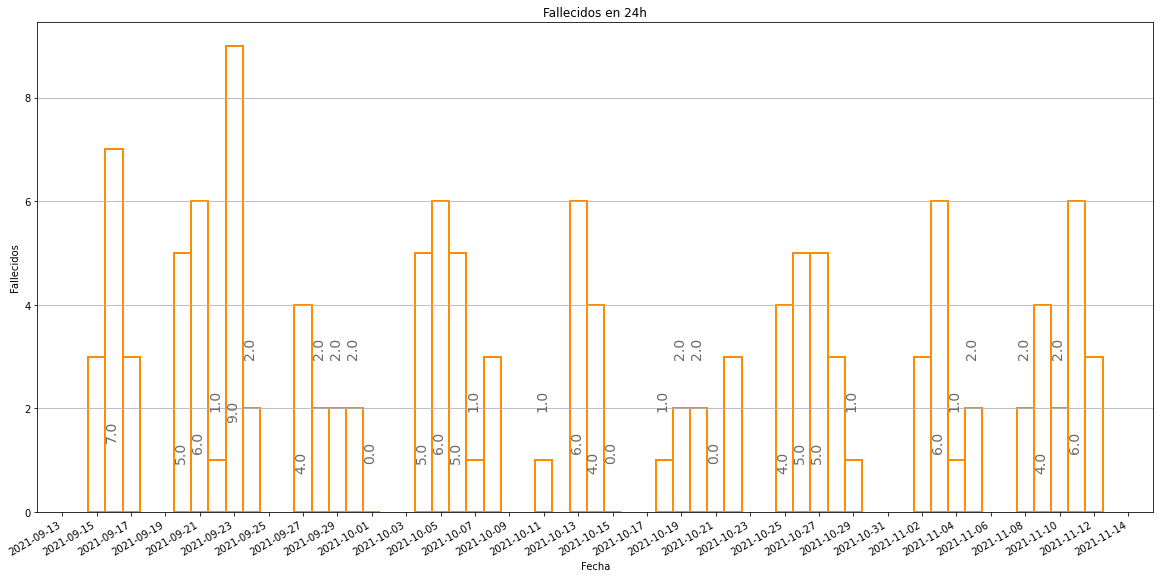

In [17]:
# Representamos los fallecidos en 24h solo de los datos de 2021

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["fallecidos_24h"],width=1,fill=False,linewidth=2,ec="darkorange")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos en 24h')
ax.set_ylabel('Fallecidos')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 2))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
fig.autofmt_xdate()

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 3:
        ax.text(i.get_x(), i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 3:
            ax.text(i.get_x(), i.get_height()+1, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

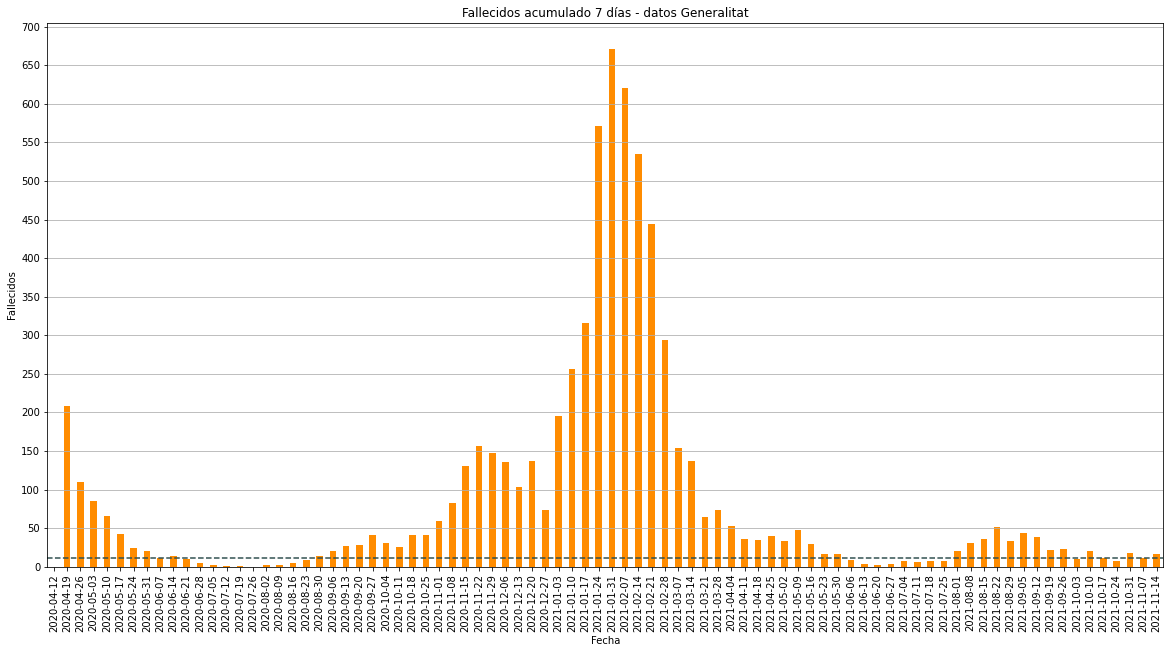

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
data_sem["fallecidos_24h"].plot.bar(rot=90,ax=ax,color="darkorange")

ax.axhline(y=data_sem["fallecidos_24h"].iloc[-2],color="darkslategray",linestyle="--",linewidth=1.5)


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos acumulado 7 días - datos Generalitat')
ax.set_ylabel('Fallecidos')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.grid()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
a=ax.set_xticklabels(data_sem.index.format(), rotation="vertical")

In [19]:
# Consulta para crear las tablas con los datos totales de las mujeres
data_mujer=pd.read_sql_query("""
                        SELECT fecha,sexo,SUM(acumulados_caso) AS casos_tot,SUM(acumulado_fallecidos) AS fallecidos_tot
                        FROM COVID_CV_GVA
                        WHERE sexo="Mujer"
                        GROUP BY fecha
                        """,con)


# Combertimos la fecha en indice y la pasamos a formato fecha
data_mujer=data_mujer.set_index("fecha")
data_mujer.index = pd.to_datetime(data_mujer.index)

# Calculamos los casos y los fallecidos en 24h
data_mujer['casos_24h']=data_mujer["casos_tot"].diff()
data_mujer['fallecidos_24h']=data_mujer["fallecidos_tot"].diff()

# Rellenamos las fechas que faltan y volvemos a poner la fecha como columna
data_mujer=data_mujer.resample("D").asfreq()
# data_mujer=data_mujer.reset_index()

data_mujer_2021=data_mujer.copy()
data_mujer_2021=data_mujer["2020-12-31":]

#---------------------------------------------------------------------------------------------------------------
# Consulta para crear las tablas con los datos totales de los hombres
data_hombre=pd.read_sql_query("""
                        SELECT fecha,sexo,SUM(acumulados_caso) AS casos_tot,SUM(acumulado_fallecidos) AS fallecidos_tot
                        FROM COVID_CV_GVA
                        WHERE sexo="Hombre"
                        GROUP BY fecha
                        """,con)


# Combertimos la fecha en indice y la pasamos a formato fecha
data_hombre=data_hombre.set_index("fecha")
data_hombre.index = pd.to_datetime(data_hombre.index)

# Calculamos los casos y los fallecidos en 24h
data_hombre['casos_24h']=data_hombre["casos_tot"].diff()
data_hombre['fallecidos_24h']=data_hombre["fallecidos_tot"].diff()

# Rellenamos las fechas que faltan y volvemos a poner la fecha como columna
data_hombre=data_hombre.resample("D").asfreq()
# data_hombre=data_hombre.reset_index()

# data_hombre.columns

data_hombre_2021=data_hombre.copy()
data_hombre_2021=data_hombre["2020-12-31":]

# print(data_hombre.tail(20))

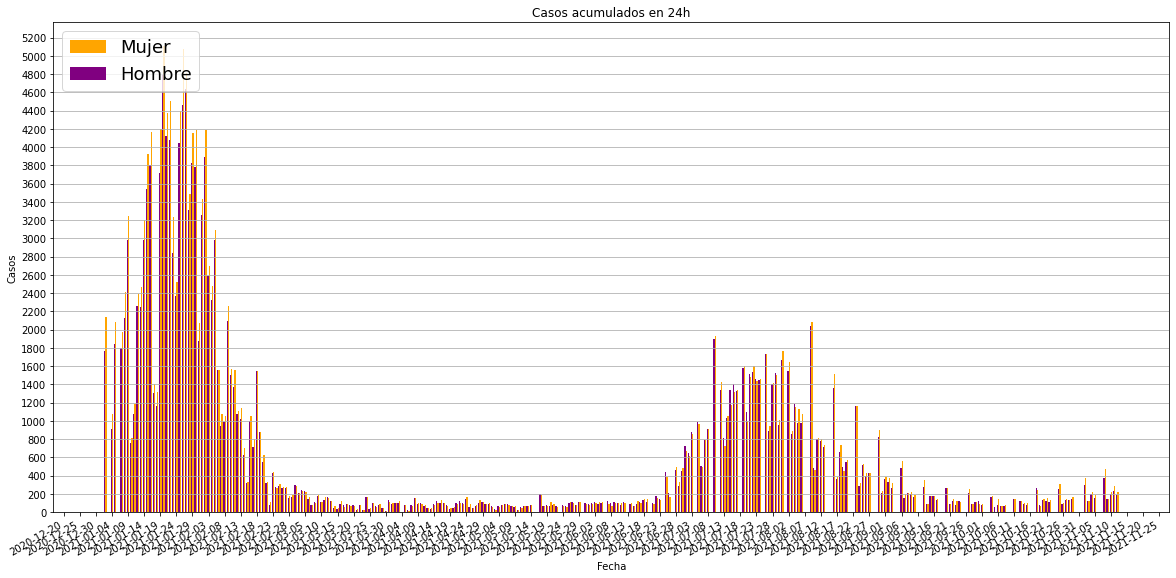

In [20]:
# Representamos los casos acumulados en 24h de los hombres y las mujeres de los últimos meses

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_mujer_2021.index,data_mujer_2021["casos_24h"],align = 'edge'
             ,width=0.4,linewidth=1,color="orange",label="Mujer")

ax.bar(data_hombre_2021.index,data_hombre_2021["casos_24h"]
             ,align = 'edge',width=-0.4,linewidth=1,color="purple",label="Hombre")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulados en 24h')
ax.set_ylabel('Casos')
ax.set_xlabel('Fecha')

plt.legend(loc=0,fontsize=18)

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 200))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig.autofmt_xdate()

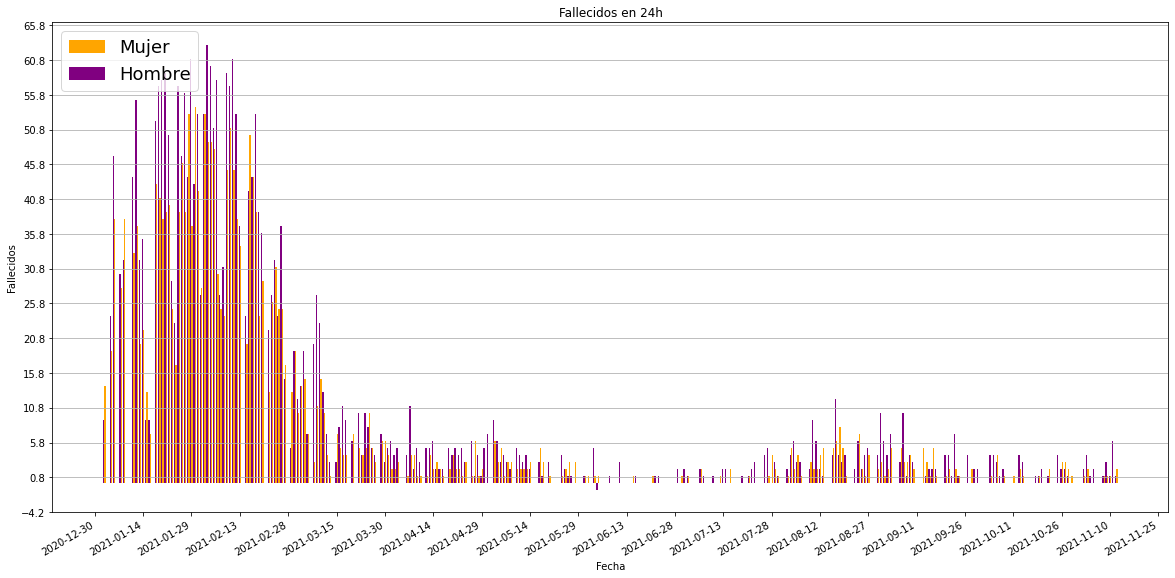

In [54]:
# Representamos los fallecidos en 24h de los hombres y las mujeres de los últimos meses

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_mujer_2021.index,data_mujer_2021["fallecidos_24h"],align = 'edge'
             ,width=0.4,linewidth=1,color="orange",label="Mujer")

ax.bar(data_hombre_2021.index,data_hombre_2021["fallecidos_24h"]
             ,align = 'edge',width=-0.4,linewidth=1,color="purple",label="Hombre")

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos en 24h')
ax.set_ylabel('Fallecidos')
ax.set_xlabel('Fecha')

plt.legend(loc=0,fontsize=18)

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 5))
ax.yaxis.grid()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
fig.autofmt_xdate()



In [22]:
# Creamos una tabla con los datos de casos y fallecidos en 24h para hombres y mujeres separados en columnas

# Copio la tabla de datos de la mujer a la que eliminamos la solumna de sexo 
data_sexo=data_mujer.copy()
data_sexo.drop("sexo",axis=1,inplace=True)

# Cambio el nombre de las columnas
data_sexo.rename(columns={"casos_24h": "casos_24h_mujer", "fallecidos_24h": "fallecidos_24h_mujer",
                         "casos_tot": "casos_tot_mujer","fallecidos_tot": "fallecidos_tot_mujer"},inplace=True)

# Añadimos a la tabla los datos del hombre
data_sexo["casos_tot_hombre"]=data_hombre["casos_tot"]
data_sexo["fallecidos_tot_hombre"]=data_hombre["fallecidos_tot"]
data_sexo["casos_24h_hombre"]=data_hombre["casos_24h"]
data_sexo["fallecidos_24h_hombre"]=data_hombre["fallecidos_24h"]

# Guardamos la tabla en un csv
data_sexo[["casos_24h_mujer","fallecidos_24h_mujer","casos_24h_hombre","fallecidos_24h_hombre"]].to_csv(path_or_buf="datos_hombre_mujer.csv")

# data_sexo[["casos_24h_mujer","fallecidos_24h_mujer","casos_24h_hombre","fallecidos_24h_hombre"]].describe()

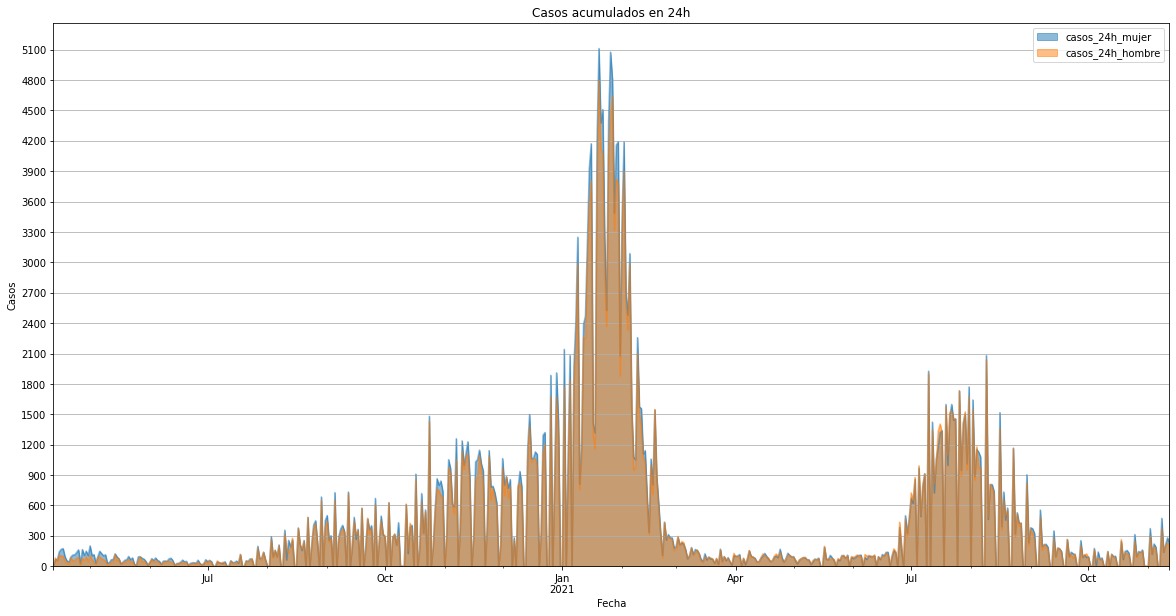

In [23]:
fig, axs = plt.subplots(figsize=(20,10))

data_sexo[["casos_24h_mujer","casos_24h_hombre"]].plot.area(ax=axs,stacked=False)

# Ponemos etiquetas y configuramos los ejes
axs.set_title('Casos acumulados en 24h')
axs.set_ylabel('Casos')
axs.set_xlabel('Fecha')

starty, endy = axs.get_ylim()
axs.set_ylim((0,endy))
axs.yaxis.set_ticks(np.arange(starty, endy, 300))
axs.yaxis.grid()

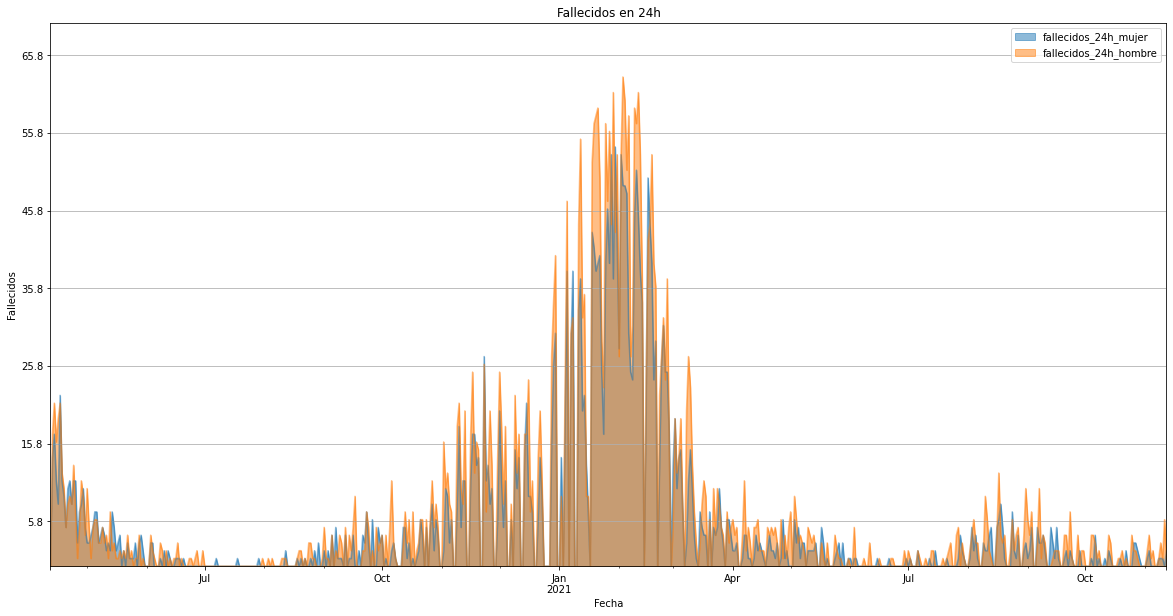

In [24]:
fig, axs = plt.subplots(figsize=(20,10))

data_sexo[["fallecidos_24h_mujer","fallecidos_24h_hombre"]].plot.area(ax=axs,stacked=False)

# Ponemos etiquetas y configuramos los ejes
axs.set_title('Fallecidos en 24h')
axs.set_ylabel('Fallecidos')
axs.set_xlabel('Fecha')

starty, endy = axs.get_ylim()
axs.yaxis.set_ticks(np.arange(starty, endy, 10))
axs.set_ylim((0,70))
axs.yaxis.grid()

In [25]:
# Consulta crear tabla con los datos totales para cada rango de edad

data_edad=pd.read_sql_query("""
                        SELECT fecha,edad,SUM(acumulados_caso) AS casos_tot,SUM(acumulado_fallecidos) AS fallecidos_tot
                        FROM COVID_CV_GVA
                        GROUP BY fecha,edad
                        """,con)

# Calculamos los casos acumulados cada 24h
cs_24h_edad=[None]*len(data_edad.index)
for i in data_edad.index[10:]:
    cs_24h_edad[i]=data_edad["casos_tot"].iloc[i]-data_edad["casos_tot"].iloc[i-10]
    data_edad["casos_24h"]=cs_24h_edad
    
# Calculamos los fallecidos cada 24h
f_24h_edad=[None]*len(data_edad.index)
for i in data_edad.index[10:]:
    f_24h_edad[i]=data_edad["fallecidos_tot"].iloc[i]-data_edad["fallecidos_tot"].iloc[i-10]
    data_edad["fallecidos_24h"]=f_24h_edad


# data_edad.tail(10)

In [26]:
# Creamos una tabla nueva solo con los casos cada 24h donde cada columna es una franja de edad

# Hacemos una copia de la tabla de la consulta de las edades para trabajar sobre ella. Si en vez de usar .copy()
# usamos = se crea un enlace y cuando modifiquemos una también se modificará la otra.
casos_24h_edad=data_edad.copy()

# Eliminamos de las columnas que no nos interesan
casos_24h_edad.drop("fallecidos_tot",axis=1,inplace=True)
casos_24h_edad.drop("casos_tot",axis=1,inplace=True)
casos_24h_edad.drop("fallecidos_24h",axis=1,inplace=True)

# Pasamos cada fila de edad a una columna
casos_24h_edad=casos_24h_edad.pivot(index='fecha', columns='edad', values='casos_24h')

# Convertimos el indice en formato fecha y rellenamos los días que faltan 
casos_24h_edad.index= pd.to_datetime(casos_24h_edad.index)
casos_24h_edad=casos_24h_edad.resample("D").asfreq()

# casos_24h_edad.tail(10)

# Guardamos la tabla en un csv
casos_24h_edad.to_csv(path_or_buf="casos_24h_edad.csv")

# casos_24h_edad.head(15)

In [27]:
# Creamos una tabla nueva solo con los fallecidos cada 24h donde cada columna es una franja de edad

# Hacemos una copia de la tabla por edades para no modificar la original
fallecidos_24h_edad=data_edad.copy()

# Eliminamos los datos que no vamos a usar
fallecidos_24h_edad.drop("fallecidos_tot",axis=1,inplace=True)
fallecidos_24h_edad.drop("casos_tot",axis=1,inplace=True)
fallecidos_24h_edad.drop("casos_24h",axis=1,inplace=True)

# Pasamos cada fila de edad a una columna
fallecidos_24h_edad=fallecidos_24h_edad.pivot(index='fecha', columns='edad', values='fallecidos_24h')

# Convertimos la fecha a formato datos y rellenamos los datos que no hay
fallecidos_24h_edad.index= pd.to_datetime(fallecidos_24h_edad.index)
fallecidos_24h_edad=fallecidos_24h_edad.resample("D").asfreq()

# fallecidos_24h_edad.tail(60)

# Guardamos la tabla en un csv
fallecidos_24h_edad.to_csv(path_or_buf="fallecidos_24h_edad.csv")

# fallecidos_24h_edad.tail(20)

In [28]:
poblacion_edad=[456897,536528,516126,648759,851588,752334,580728,437862,227224,49307]
a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

# Eliminamos el indice de las fechas para poder operar con la tabla
casos_24h_edad=casos_24h_edad.reset_index()

# Creamos un DataFrame solo con fechas donde guardaremos la IA 14d por rango de edad
IA_14d_edad=casos_24h_edad.copy()
for j in list(range(10)):
    IA_14d_edad.drop(a[j],axis=1,inplace=True)  
    
# Calculo de la IA 14d por rango de edad
for j in list(range(10)):
    IA_temp_edad=[None]*13
    
    for i in casos_24h_edad[a[j]].index[13:]:
        if (not np.isnan(casos_24h_edad[a[j]].iloc[i])):
            IA_temp_edad.append("{:.2f}".format(casos_24h_edad[a[j]].iloc[i+1-14:i+1].sum()*1e5/poblacion_edad[j]))
        else:
            IA_temp_edad.append(None)
        
    IA_temp_edad=np.array(IA_temp_edad,dtype=float)
    IA_14d_edad[a[j]]=IA_temp_edad


# Volvemos a poner el indice de las fechas
casos_24h_edad=casos_24h_edad.set_index("fecha")

In [29]:
IA_14d_edad=IA_14d_edad.set_index("fecha")
IA_14d_edad.tail(10)

# Guardamos la tabla en un csv
IA_14d_edad.to_csv(path_or_buf="IA_14d_edad.csv")

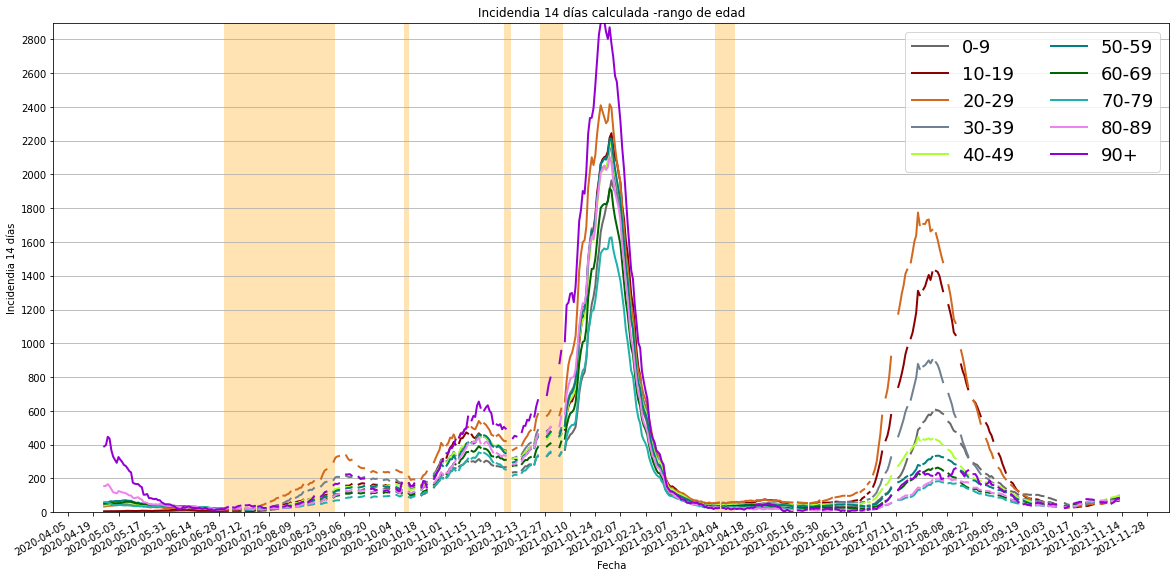

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["dimgray","darkred","chocolate","slategray","greenyellow","teal","darkgreen","lightseagreen","violet"
   ,"darkviolet"]

for i in list(range(10)):
    ax.plot(IA_14d_edad.index,IA_14d_edad[a[i]],color=b[i],label=a[i],linewidth=2)
ax.legend(ncol=2,fontsize=18)

# Linea comiendo-fin vacunacion
# ax.axvline(x="2021-02-17", ymin=0, ymax=1,color="darkviolet") # Edad 90+
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="darkviolet",linestyle="--")
# ax.text("2021-02-18",2400,"inicio 90+",fontsize=15,color="darkviolet")
# ax.text("2021-05-07",2200,"fin 90+",fontsize=15,color="darkviolet")

# ax.axvline(x="2021-02-22", ymin=0, ymax=1,color="violet") # Edad 80-89
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="violet",linestyle="--")
# ax.text("2021-02-22",2100,"inicio 80-89",fontsize=15,color="violet")
# ax.text("2021-05-07",2000,"fin 80-89",fontsize=15,color="violet")

# ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="lightseagreen") # Edad 70-79
# ax.text("2021-04-07",2600," inicio 70-79",fontsize=15,color="lightseagreen")

# ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="darkgreen") # Edad 60-69
# ax.text("2021-04-07",1600,"inicio 60-69",fontsize=15,color="darkgreen")

# ax.axvline(x="2021-05-17", ymin=0, ymax=1,color="teal") # Edad 50-59
# ax.text("2021-05-18",2400,"inicio 50-59",fontsize=15,color="teal")

# ax.axvline(x="2021-06-07", ymin=0, ymax=1,color="greenyellow") # Edad 40-49
# ax.text("2021-06-08",1800,"inicio 40-49",fontsize=15,color="greenyellow")


# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días calculada -rango de edad')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

ax.set_ylim((0,2900))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 200))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))

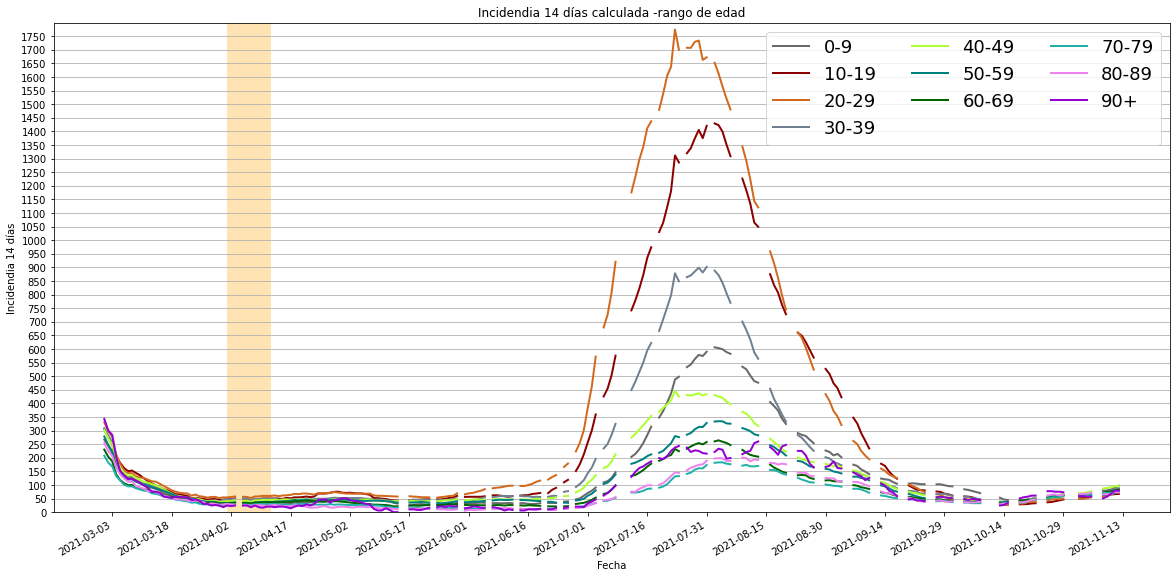

In [61]:
range_IA14d=IA_14d_edad.copy()
range_IA14d=range_IA14d["2021-03-01":]

fig, ax = plt.subplots(figsize=(20,10))
a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["dimgray","darkred","chocolate","slategray","greenyellow","teal","darkgreen","lightseagreen","violet"
   ,"darkviolet"]

for i in list(range(10)):
    ax.plot(range_IA14d.index,range_IA14d[a[i]],color=b[i],label=a[i],linewidth=2)
ax.legend(ncol=3,fontsize=18)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Linea comiendo-fin vacunacion
# ax.axvline(x="2021-02-17", ymin=0, ymax=1,color="darkviolet") # Edad 90+
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="darkviolet",linestyle="--")
# ax.text("2021-05-07",200,"fin 90+",fontsize=15,color="darkviolet")

# # ax.axvline(x="2021-02-22", ymin=0, ymax=1,color="violet") # Edad 80-89
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="violet",linestyle="--")
# ax.text("2021-05-07",150,"fin 80-89",fontsize=15,color="violet")

# ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="lightseagreen") # Edad 70-79
# ax.text("2021-04-07",200," inicio 70-79",fontsize=15,color="lightseagreen")

# ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="darkgreen") # Edad 60-69
# ax.text("2021-04-07",150,"inicio 60-69",fontsize=15,color="darkgreen")

# ax.axvline(x="2021-05-17", ymin=0, ymax=1,color="teal") # Edad 50-59
# ax.text("2021-05-18",200,"inicio 50-59",fontsize=15,color="teal")

# ax.axvline(x="2021-06-07", ymin=0, ymax=1,color="greenyellow") # Edad 40-49
# ax.text("2021-06-08",160,"inicio 40-49",fontsize=15,color="greenyellow")

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días calculada -rango de edad')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

ax.set_ylim((0,1800))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))

Text(2021-06-07, 600, 'Vacunación')

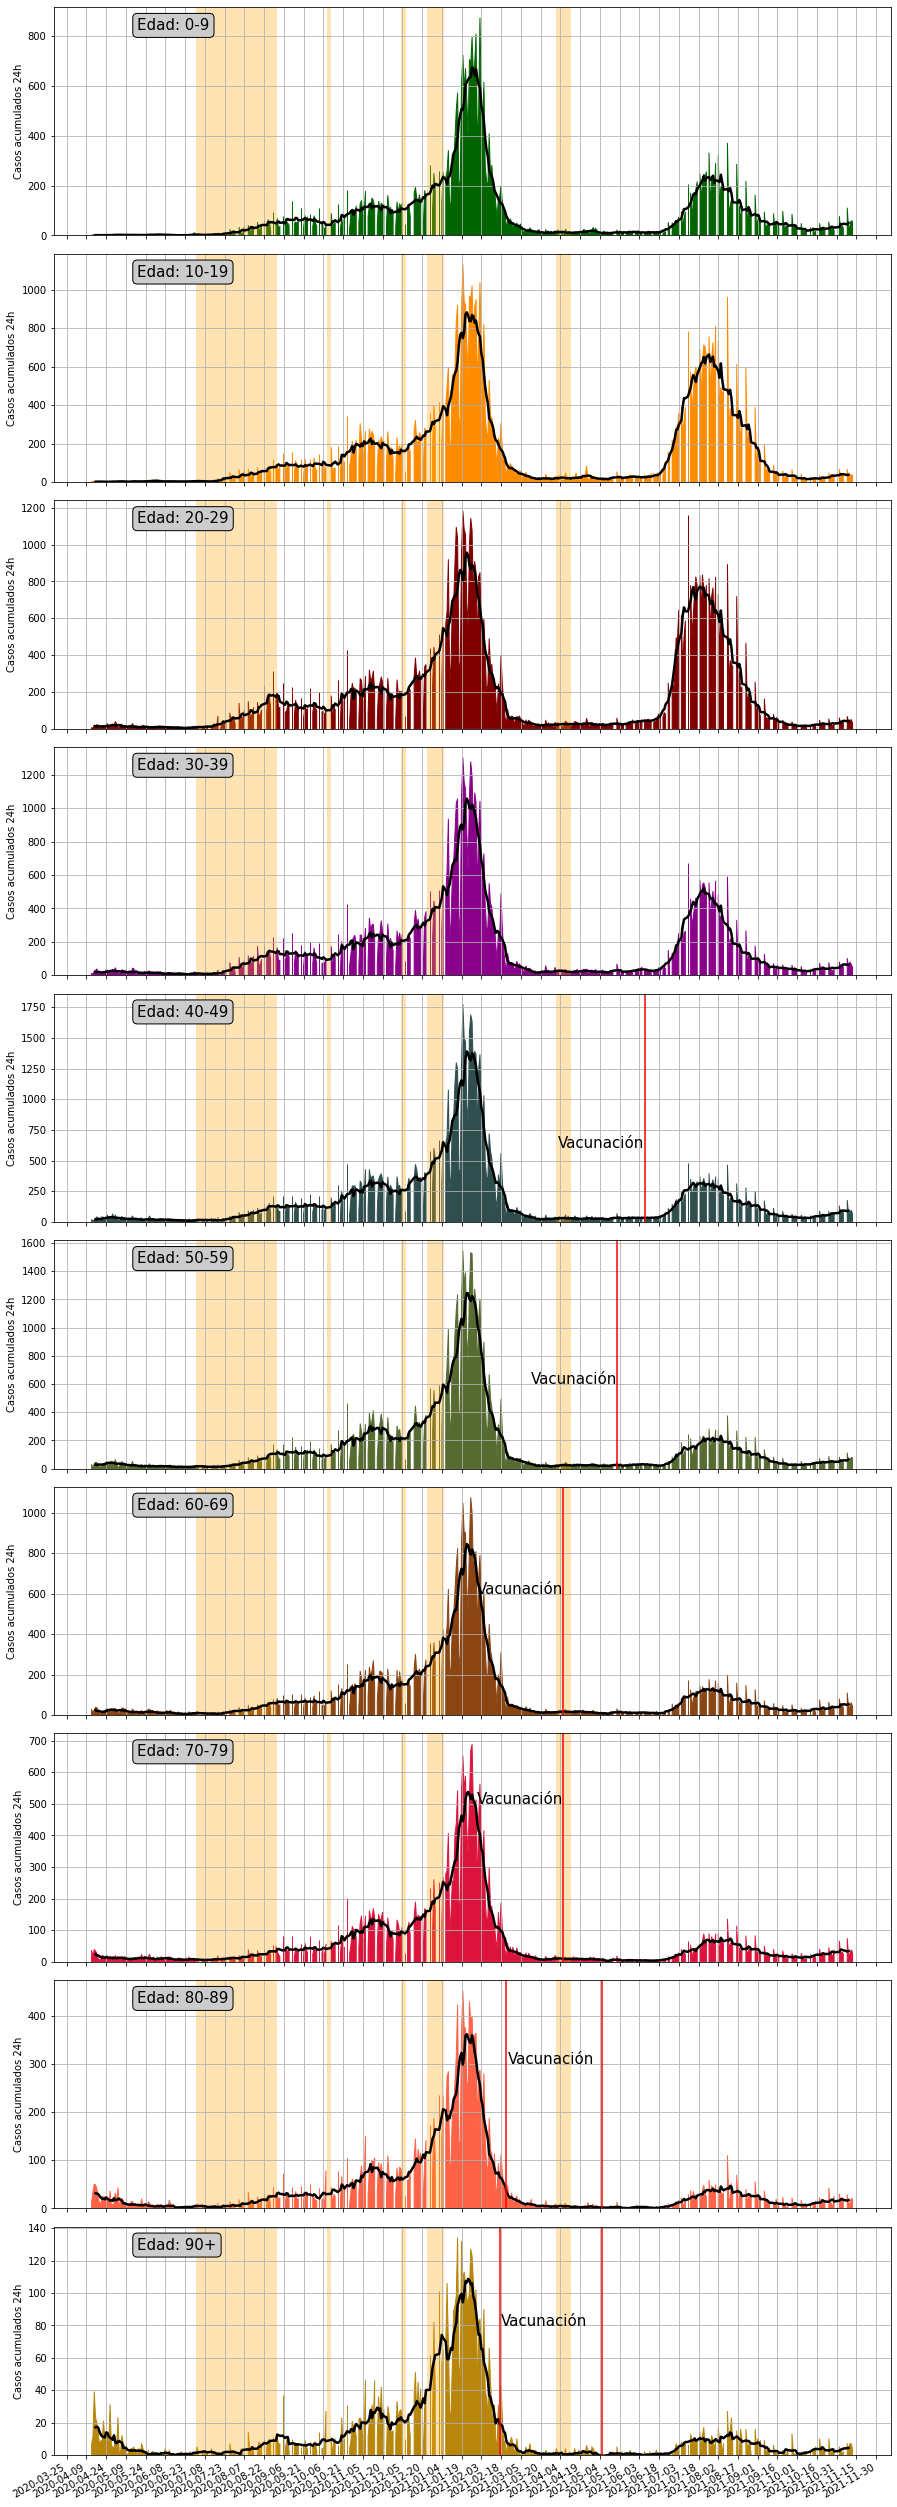

In [32]:
# Representamos los casos acumulados en 24h para cada rango de edad, cada uno en una figura.

fig, axs = plt.subplots(nrows=10, ncols=1,figsize=(15,50),sharex=True)
fig.subplots_adjust(hspace=0.08)

a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["Edad: 0-9","Edad: 10-19","Edad: 20-29","Edad: 30-39","Edad: 40-49","Edad: 50-59",
   "Edad: 60-69","Edad: 70-79","Edad: 80-89","Edad: 90+"]

color_val=["darkgreen","darkorange","maroon","darkmagenta","darkslategray","darkolivegreen","saddlebrown",
      "crimson","tomato","darkgoldenrod"]

# Copiamos los datos en una tabla nueva para poder calcular luego la tendencia de los datos
temp2=casos_24h_edad.copy()
temp2=temp2.dropna(how='any',axis=0)

# Argumentos que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

for i in list(range(10)):
    axs[i].stackplot(casos_24h_edad.index,casos_24h_edad[a[i]],color=color_val[i])
    
    # Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
    decompose = seasonal_decompose(temp2[a[i]],period=7)
    # Representamos el resultado sobre los datos
    axs[i].plot(decompose.trend.index, decompose.trend, c='black',linewidth=2.5)
    
    # Sombreamos las epocas de vacaciones
    axs[i].axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)
    
    # Titulo y configuración de los ejes
    axs[i].set_ylabel('Casos acumulados 24h')
    axs[i].yaxis.grid()
    starty, endy = axs[i].get_ylim()
    axs[i].set_ylim((0,endy))
    axs[i].xaxis.grid()
    
    # Texto en el que indicamos que estamos representando en cada figura
    axs[i].annotate(b[i],xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,bbox=bbox_args)


# Configuración eje X de la última gráfica
fig.autofmt_xdate()
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=15))


axs[9].axvline(x="2021-02-17", ymin=0, ymax=1,color="red") # Edad 90+
axs[9].axvline(x="2021-05-06", ymin=0, ymax=1,color="red")
axs[9].text("2021-02-18",80,"Vacunación",fontsize=15)

axs[8].axvline(x="2021-02-22", ymin=0, ymax=1,color="red") # Edad 80-89
axs[8].axvline(x="2021-05-06", ymin=0, ymax=1,color="red")
axs[8].text("2021-02-23",300,"Vacunación",fontsize=15)

axs[7].axvline(x="2021-04-06", ymin=0, ymax=1,color="red") # Edad 70-79
axs[7].text("2021-04-06",500,"Vacunación",fontsize=15,horizontalalignment="right")

axs[6].axvline(x="2021-04-06", ymin=0, ymax=1,color="red") # Edad 60-69
axs[6].text("2021-04-06",600,"Vacunación",fontsize=15,horizontalalignment="right")

axs[5].axvline(x="2021-05-17", ymin=0, ymax=1,color="red") # Edad 50-59
axs[5].text("2021-05-17",600,"Vacunación",fontsize=15,horizontalalignment="right")

axs[4].axvline(x="2021-06-07", ymin=0, ymax=1,color="red") # Edad 40-49
axs[4].text("2021-06-07",600,"Vacunación",fontsize=15,horizontalalignment="right")


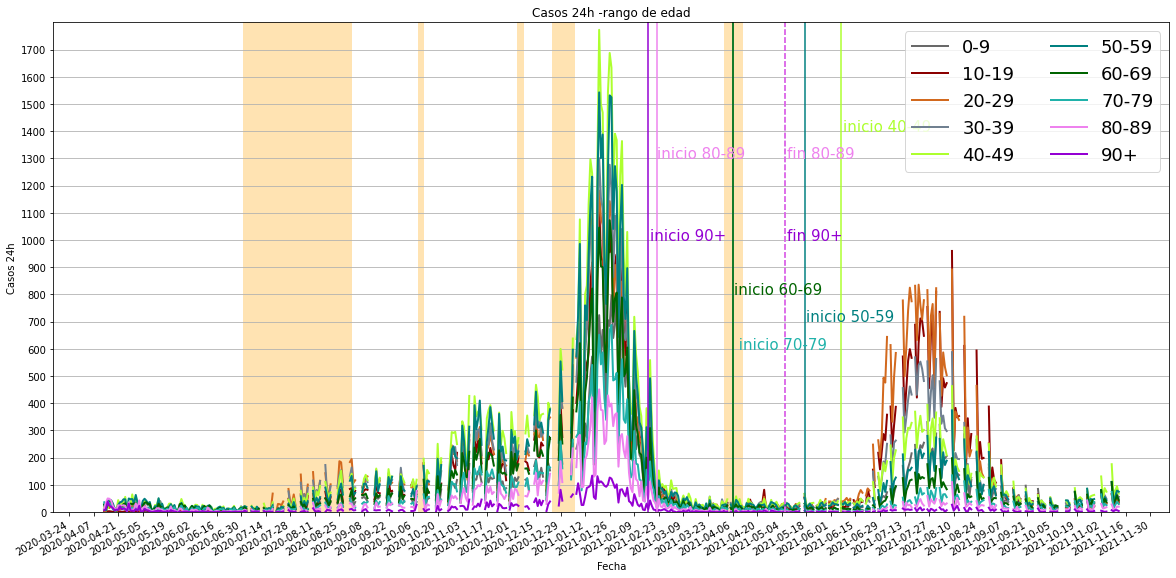

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["dimgray","darkred","chocolate","slategray","greenyellow","teal","darkgreen","lightseagreen","violet"
   ,"darkviolet"]

for i in list(range(10)):
    ax.plot(casos_24h_edad.index,casos_24h_edad[a[i]],color=b[i],label=a[i],linewidth=2)
ax.legend(ncol=2,fontsize=18)

# Linea comiendo-fin vacunacion
ax.axvline(x="2021-02-17", ymin=0, ymax=1,color="darkviolet") # Edad 90+
ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="darkviolet",linestyle="--")
ax.text("2021-02-18",1000,"inicio 90+",fontsize=15,color="darkviolet")
ax.text("2021-05-07",1000,"fin 90+",fontsize=15,color="darkviolet")

ax.axvline(x="2021-02-22", ymin=0, ymax=1,color="violet") # Edad 80-89
ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="violet",linestyle="--")
ax.text("2021-02-22",1300,"inicio 80-89",fontsize=15,color="violet")
ax.text("2021-05-07",1300,"fin 80-89",fontsize=15,color="violet")

ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="lightseagreen") # Edad 70-79
ax.text("2021-04-07",600," inicio 70-79",fontsize=15,color="lightseagreen")

ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="darkgreen") # Edad 60-69
ax.text("2021-04-07",800,"inicio 60-69",fontsize=15,color="darkgreen")

ax.axvline(x="2021-05-17", ymin=0, ymax=1,color="teal") # Edad 50-59
ax.text("2021-05-18",700,"inicio 50-59",fontsize=15,color="teal")

ax.axvline(x="2021-06-07", ymin=0, ymax=1,color="greenyellow") # Edad 40-49
ax.text("2021-06-08",1400,"inicio 40-49",fontsize=15,color="greenyellow")


# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos 24h -rango de edad')
ax.set_ylabel('Casos 24h')
ax.set_xlabel('Fecha')

ax.set_ylim((0,1800))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 100))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))

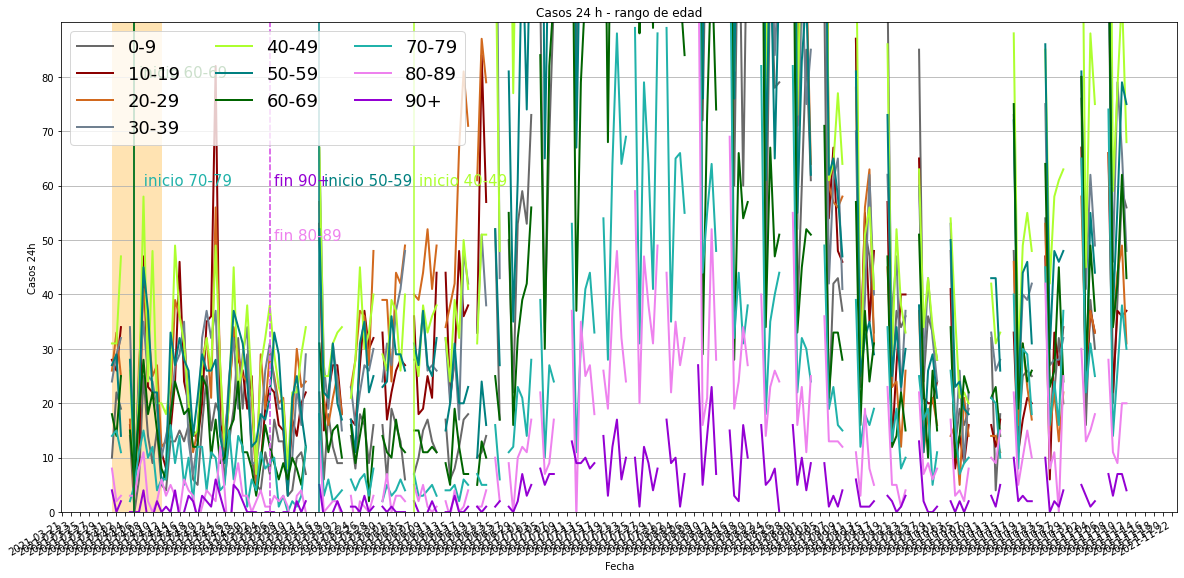

In [34]:
range_casos24h=casos_24h_edad.copy()
range_casos24h=range_casos24h["2021-04-01":]

fig, ax = plt.subplots(figsize=(20,10))
a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["dimgray","darkred","chocolate","slategray","greenyellow","teal","darkgreen","lightseagreen","violet"
   ,"darkviolet"]

for i in list(range(10)):
    ax.plot(range_casos24h.index,range_casos24h[a[i]],color=b[i],label=a[i],linewidth=2)
ax.legend(ncol=3,fontsize=18)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Linea comiendo-fin vacunacion
# ax.axvline(x="2021-02-17", ymin=0, ymax=1,color="darkviolet") # Edad 90+
ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="darkviolet",linestyle="--")
ax.text("2021-05-07",60,"fin 90+",fontsize=15,color="darkviolet")

# ax.axvline(x="2021-02-22", ymin=0, ymax=1,color="violet") # Edad 80-89
ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="violet",linestyle="--")
ax.text("2021-05-07",50,"fin 80-89",fontsize=15,color="violet")

ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="lightseagreen") # Edad 70-79
ax.text("2021-04-07",60," inicio 70-79",fontsize=15,color="lightseagreen")

ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="darkgreen") # Edad 60-69
ax.text("2021-04-07",80,"inicio 60-69",fontsize=15,color="darkgreen")

ax.axvline(x="2021-05-17", ymin=0, ymax=1,color="teal") # Edad 50-59
ax.text("2021-05-18",60,"inicio 50-59",fontsize=15,color="teal")

ax.axvline(x="2021-06-07", ymin=0, ymax=1,color="greenyellow") # Edad 40-49
ax.text("2021-06-08",60,"inicio 40-49",fontsize=15,color="greenyellow")

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos 24 h - rango de edad')
ax.set_ylabel('Casos 24h')
ax.set_xlabel('Fecha')

ax.set_ylim((0,90))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

Text(2021-05-17, 6, 'Vacunación')

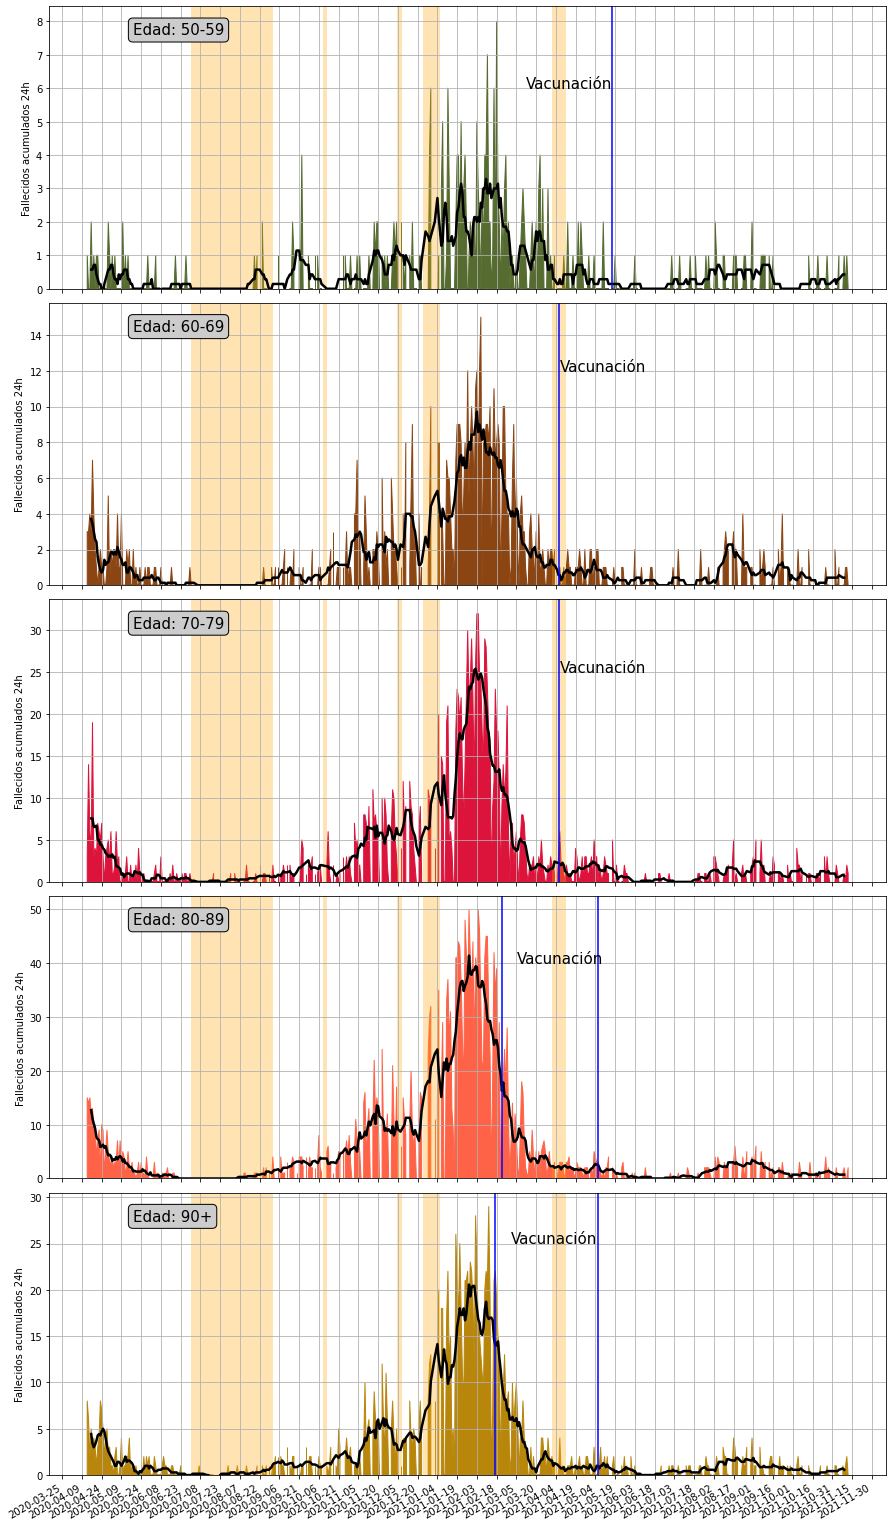

In [35]:
# Representamos los casos acumulados en 24h para cada rango de edad, cada uno en una figura.

fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(15,30),sharex=True)
fig.subplots_adjust(hspace=0.05)

a=["50-59","60-69","70-79","80-89","90+"]

b=["Edad: 50-59","Edad: 60-69","Edad: 70-79","Edad: 80-89","Edad: 90+"]

color_val=["darkolivegreen","saddlebrown","crimson","tomato","darkgoldenrod"]

# Copiamos los datos en una tabla nueva para poder calcular luego la tendencia de los datos
temp2=fallecidos_24h_edad.copy()
temp2=temp2.dropna(how='any',axis=0)

# Argumentos que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

for i in list(range(5)):
    axs[i].stackplot(fallecidos_24h_edad.index,fallecidos_24h_edad[a[i]],color=color_val[i])
    
    # Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
    decompose = seasonal_decompose(temp2[a[i]],period=7)
    # Representamos el resultado sobre los datos
    axs[i].plot(decompose.trend.index, decompose.trend, c='black',linewidth=2.5)
    
    # Sombreamos las epocas de vacaciones
    axs[i].axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
    axs[i].axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)
    
    # Titulo y configuración de los ejes
    axs[i].set_ylabel('Fallecidos acumulados 24h')
    axs[i].yaxis.grid()
    starty, endy = axs[i].get_ylim()
    axs[i].set_ylim((0,endy))
    axs[i].xaxis.grid()
    
    # Texto en el que indicamos que estamos representando en cada figura
    axs[i].annotate(b[i],xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,bbox=bbox_args)


# Configuración eje X de la última gráfica
fig.autofmt_xdate()
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=15))


axs[4].axvline(x="2021-02-17", ymin=0, ymax=1,color="blue")
axs[4].axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs[4].text("2021-03-01",25,"Vacunación",fontsize=15)

axs[3].axvline(x="2021-02-22", ymin=0, ymax=1,color="blue")
axs[3].axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs[3].text("2021-03-05",40,"Vacunación",fontsize=15)

axs[2].axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs[2].text("2021-04-07",25,"Vacunación",fontsize=15)

axs[1].axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs[1].text("2021-04-07",12,"Vacunación",fontsize=15)

axs[0].axvline(x="2021-05-17", ymin=0, ymax=1,color="blue")
axs[0].text("2021-05-17",6,"Vacunación",fontsize=15,horizontalalignment="right")


In [36]:
# Creamos una nueva tabla donde vamos a calcular el porcentaje respecto a los casos totales de ese día de los casos
# de cada rango de edad. Para ello usamos dos tablas:

# data_edad: Tabla con datos separados por edades
# temp: Tabla con datos en la que se ha sumado los datos de edad y sexo

por_casos_24h=[None]*len(data_edad.index)

for i in data_edad.index[10:]:
    por_casos_24h[i]=(data_edad["casos_24h"].iloc[i]/temp['casos_24h'].iloc[int(i/10)])*100

data_edad["por_casos_24h"]=por_casos_24h

# data_temp.tail(10)


<ipython-input-36-e3c38d26acc1>:10: RuntimeWarning: invalid value encountered in double_scalars
  por_casos_24h[i]=(data_edad["casos_24h"].iloc[i]/temp['casos_24h'].iloc[int(i/10)])*100


In [37]:
# Creamos una nueva tabla donde vamos a calcular el porcentaje respecto a los casos totales de ese día de los casos
# de cada rango de edad. Para ello usamos dos tablas:

# data_edad: Tabla con datos separados por edades
# temp: Tabla con datos en la que se ha sumado los datos de edad y sexo

por_fallecidos_24h=[None]*len(data_edad.index)

for i in data_edad.index[10:]:
    por_fallecidos_24h[i]=(data_edad["fallecidos_24h"].iloc[i]/temp['fallecidos_24h'].iloc[int(i/10)])*100

data_edad["por_fallecidos_24h"]=por_fallecidos_24h

data_edad.tail(10)

<ipython-input-37-462602fe2408>:10: RuntimeWarning: invalid value encountered in double_scalars
  por_fallecidos_24h[i]=(data_edad["fallecidos_24h"].iloc[i]/temp['fallecidos_24h'].iloc[int(i/10)])*100
<ipython-input-37-462602fe2408>:10: RuntimeWarning: divide by zero encountered in double_scalars
  por_fallecidos_24h[i]=(data_edad["fallecidos_24h"].iloc[i]/temp['fallecidos_24h'].iloc[int(i/10)])*100


fecha   edad  casos_tot  fallecidos_tot  casos_24h  \
4820   2021-11-12    0-9      39810               0       56.0   
4821   2021-11-12  10-19      70091               3       37.0   
4822   2021-11-12  20-29      81998               7       31.0   
4823   2021-11-12  30-39      74269              25       48.0   
4824   2021-11-12  40-49      85542              98       68.0   
4825   2021-11-12  50-59      72568             297       75.0   
4826   2021-11-12  60-69      47824             835       43.0   
4827   2021-11-12  70-79      30852            1880       30.0   
4828   2021-11-12  80-89      20953            3159       20.0   
4829   2021-11-12    90+       6653            1570        4.0   

      fallecidos_24h  por_casos_24h  por_fallecidos_24h  
4820             0.0      13.592233            0.000000  
4821             0.0       8.980583            0.000000  
4822             0.0       7.524272            0.000000  
4823             0.0      11.650485            0.000000  
4824             0.0      16.504854            0.000000  
4825             0.0      18.203883            0.000000  
4826             0.0      10.436893            0.000000  
4827             1.0       7.281553           33.333333  
4828             2.0       4.854369           66.666667  
4829             0.0       0.970874            0.000000

In [38]:
# Creamos una tabla nueva solo con el porcentaje de los casos cada 24h donde cada columna es una franja de edad

# Hacemos una copia de la tabla de la consulta de las edades para trabajar sobre ella.
por_casos_24h_edad=data_edad.copy()

# Eliminamos los datos que no vamos a usar
por_casos_24h_edad.drop("fallecidos_tot",axis=1,inplace=True)
por_casos_24h_edad.drop("fallecidos_24h",axis=1,inplace=True)
por_casos_24h_edad.drop("por_fallecidos_24h",axis=1,inplace=True)
por_casos_24h_edad.drop("casos_tot",axis=1,inplace=True)
por_casos_24h_edad.drop("casos_24h",axis=1,inplace=True)

# Pasamos cada fila de edad a una columna
por_casos_24h_edad=por_casos_24h_edad.pivot(index='fecha', columns='edad', values='por_casos_24h')
por_casos_24h_edad.head(20)

# Convertimos la fecha a formato datos y rellenamos los datos que no hay
por_casos_24h_edad.index= pd.to_datetime(por_casos_24h_edad.index)
por_casos_24h_edad=por_casos_24h_edad.resample("D").asfreq()

# Guardamos la tabla en un csv
por_casos_24h_edad.to_csv(path_or_buf="por_casos_24h_edad.csv")

por_casos_24h_edad.tail()

edad              0-9     10-19      20-29      30-39      40-49      50-59  \
fecha                                                                         
2021-11-08  12.956419  7.773852   7.773852  11.896349  20.730271  13.074205   
2021-11-09   7.142857  7.857143  12.142857  16.428571  21.071429  13.214286   
2021-11-10   9.352518  8.872902  10.551559  18.944844  18.705036  13.429257   
2021-11-11  11.545988  7.045010   9.589041  12.915851  18.590998  15.459883   
2021-11-12  13.592233  8.980583   7.524272  11.650485  16.504854  18.203883   

edad            60-69     70-79     80-89       90+  
fecha                                                
2021-11-08  12.956419  8.716137  3.297998  0.824499  
2021-11-09  12.142857  5.000000  3.928571  1.071429  
2021-11-10  10.071942  6.235012  2.158273  1.678657  
2021-11-11  12.133072  7.436399  3.913894  1.369863  
2021-11-12  10.436893  7.281553  4.854369  0.970874

In [39]:
# Creamos una tabla nueva solo con el porcentaje de los casos cada 24h donde cada columna es una franja de edad

# Hacemos una copia de la tabla de la consulta de las edades para trabajar sobre ella.
por_fallecidos_24h_edad=data_edad.copy()

# Eliminamos los datos que no vamos a usar
por_fallecidos_24h_edad.drop("fallecidos_tot",axis=1,inplace=True)
por_fallecidos_24h_edad.drop("fallecidos_24h",axis=1,inplace=True)
por_fallecidos_24h_edad.drop("casos_tot",axis=1,inplace=True)
por_fallecidos_24h_edad.drop("casos_24h",axis=1,inplace=True)
por_fallecidos_24h_edad.drop("por_casos_24h",axis=1,inplace=True)

# Pasamos cada fila de edad a una columna
por_fallecidos_24h_edad=por_fallecidos_24h_edad.pivot(index='fecha', columns='edad', values='por_fallecidos_24h')

# Convertimos la fecha a formato datos y rellenamos los datos que no hay
por_fallecidos_24h_edad.index= pd.to_datetime(por_fallecidos_24h_edad.index)
por_fallecidos_24h_edad=por_fallecidos_24h_edad.resample("D").asfreq()

# Guardamos la tabla en un csv
por_fallecidos_24h_edad.to_csv(path_or_buf="por_fallecidos_24h_edad.csv")

# por_fallecidos_24h_edad.tail()

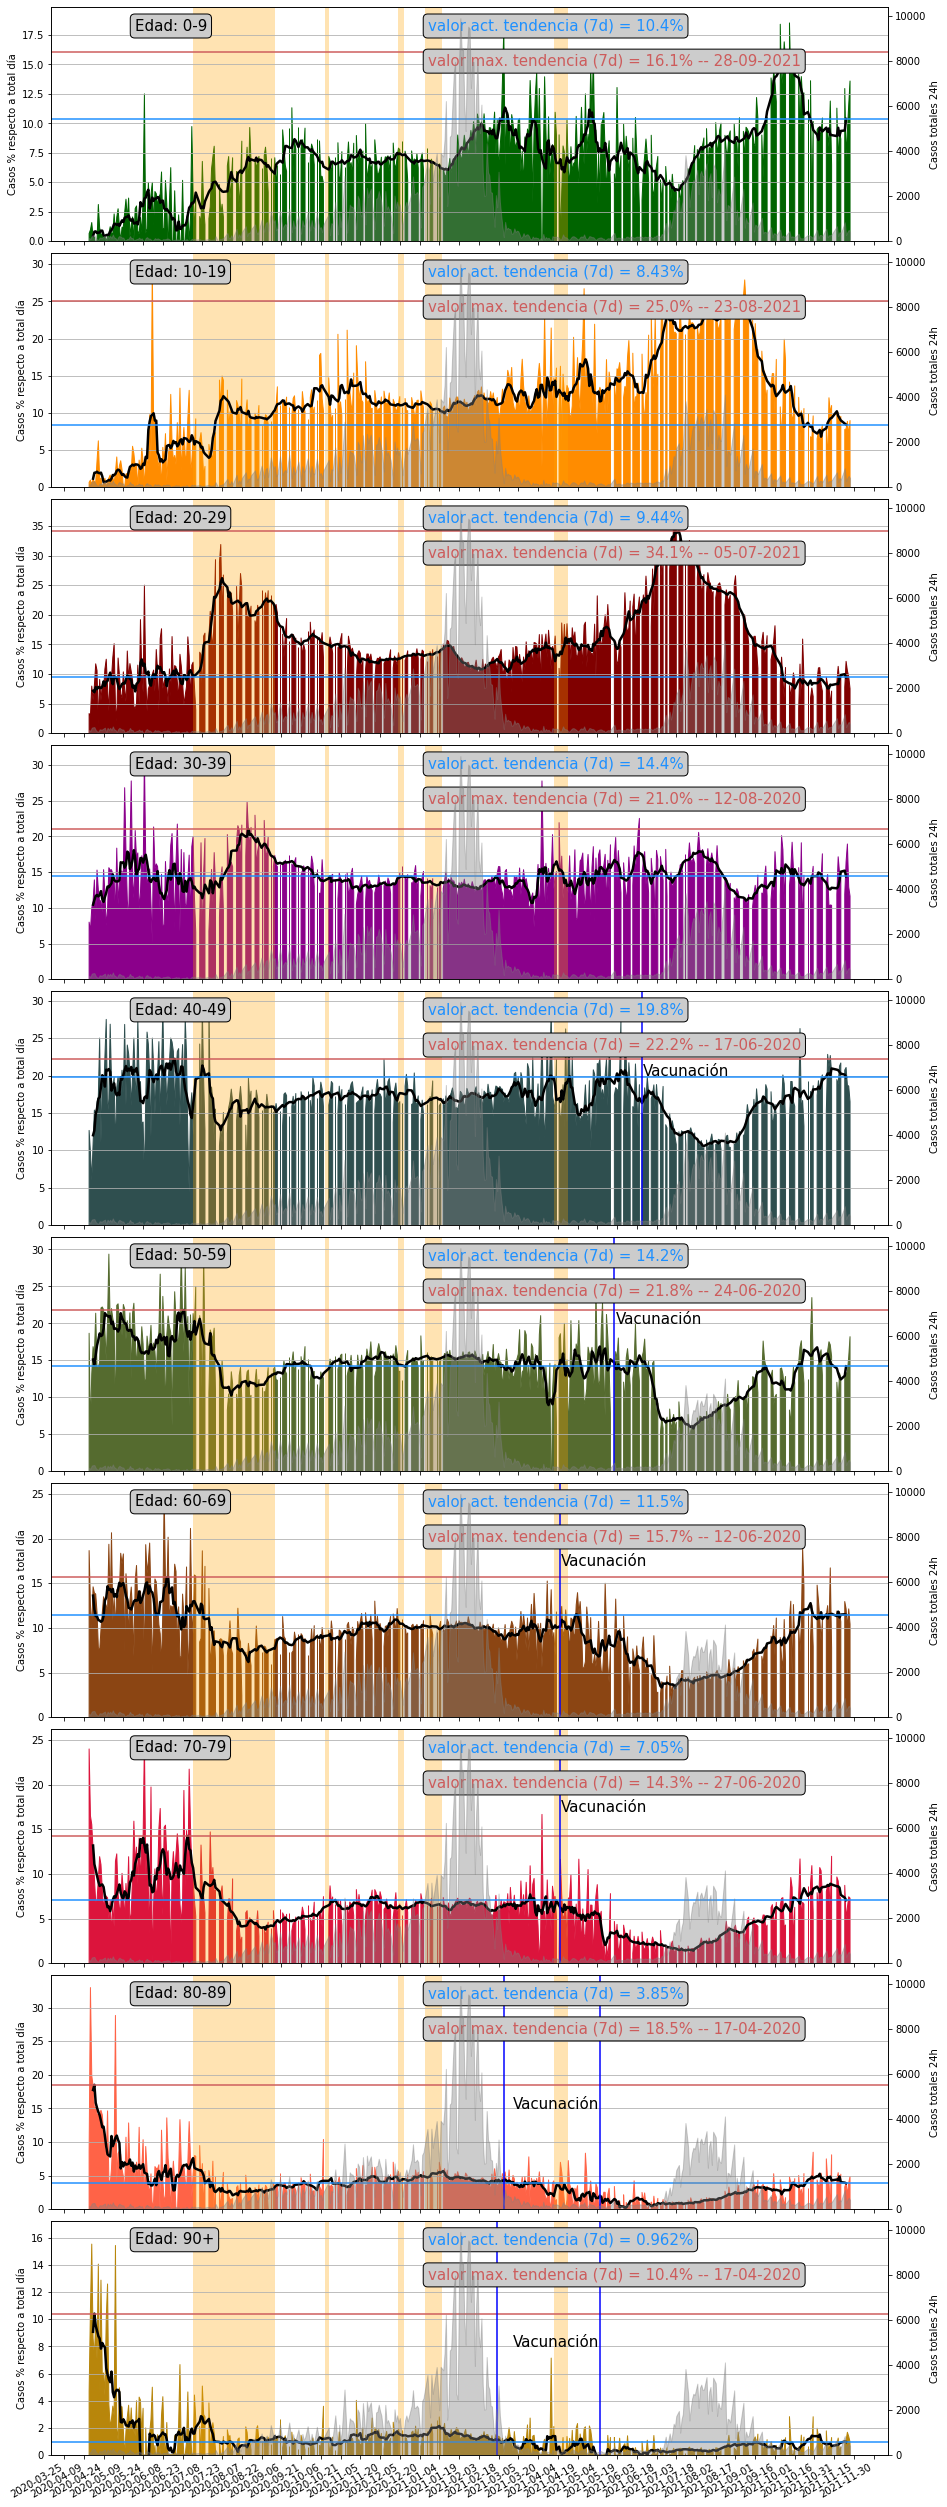

In [40]:
# Representamos el porcentaje de los casos de cada franja de edad.
fig, (axs11,axs12,axs13,axs14,axs15,axs16,axs17,axs18,axs19,axs110) = plt.subplots(10,1,figsize=(15,50))
fig.subplots_adjust(hspace=0.05)

a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

b=["Edad: 0-9","Edad: 10-19","Edad: 20-29","Edad: 30-39","Edad: 40-49","Edad: 50-59",
   "Edad: 60-69","Edad: 70-79","Edad: 80-89","Edad: 90+"]

color_val=["darkgreen","darkorange","maroon","darkmagenta","darkslategray","darkolivegreen","saddlebrown",
      "crimson","tomato","darkgoldenrod"]

axes1=[axs11,axs12,axs13,axs14,axs15,axs16,axs17,axs18,axs19,axs110]

# Parámetros que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

# Copiamos los datos en una tabla nueva para poder calcular luego la tendencia de los datos
temp2=por_casos_24h_edad.copy()
temp2=temp2.dropna(how='any',axis=0)


for i in list(range(10)):
    axes1[i].stackplot(por_casos_24h_edad.index,por_casos_24h_edad[a[i]],color=color_val[i])
    
    # Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
    decompose = seasonal_decompose(temp2[a[i]],period=7)
    # Representamos el resultado sobre los datos
    axes1[i].plot(decompose.trend.index, decompose.trend, c='black',linewidth=2.5)
    
    # Linea horizontal con el último valor calculado de la tendencia de los datos
    axes1[i].axhline(y=decompose.trend.iloc[-4],color="dodgerblue")
    axes1[i].axhline(y=float(decompose.trend.iloc[:].dropna().max()),color="indianred")

    # Sombreamos las epocas de vacaciones
    axes1[i].axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

    # Titulo y configuración de los ehes
    axes1[i].set_ylabel('Casos % respecto a total día')
    axes1[i].yaxis.grid()
    starty, endy = axes1[i].get_ylim()
    axes1[i].set_ylim((0,endy))
    
    # Texto en el que indicamos que estamos representando en cada figura
    axes1[i].annotate(b[i],xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,bbox=bbox_args)
    axes1[i].annotate('valor act. tendencia (7d) = {:.3}%'.format(decompose.trend.iloc[-4]),xy=(0.45, 0.9)
                      , xycoords='axes fraction',fontsize=15,color="dodgerblue",bbox=bbox_args)
    axes1[i].annotate("valor max. tendencia (7d) = {:.3}% -- {}".format(decompose.trend.iloc[:].dropna().max(),
                                                                   decompose.trend.idxmax(axis=0).strftime('%d-%m-%Y'))
                      ,xy=(0.45, 0.75), xycoords='axes fraction',fontsize=15,color="indianred",bbox=bbox_args)

axs110.axvline(x="2021-02-17", ymin=0, ymax=1,color="blue")
axs110.axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs110.text("2021-03-01",8,"Vacunación",fontsize=15)

axs19.axvline(x="2021-02-22", ymin=0, ymax=1,color="blue")
axs19.axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs19.text("2021-03-01",15,"Vacunación",fontsize=15)

axs18.axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs18.text("2021-04-06",17,"Vacunación",fontsize=15)

axs17.axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs17.text("2021-04-06",17,"Vacunación",fontsize=15)

axs16.axvline(x="2021-05-17", ymin=0, ymax=1,color="blue")
axs16.text("2021-05-18",20,"Vacunación",fontsize=15)

axs15.axvline(x="2021-06-07", ymin=0, ymax=1,color="blue")
axs15.text("2021-06-08",20,"Vacunación",fontsize=15)

axs21=axs11.twinx() 
axs22=axs12.twinx()
axs23=axs13.twinx()
axs24=axs14.twinx()
axs25=axs15.twinx()
axs26=axs16.twinx()
axs27=axs17.twinx()
axs28=axs18.twinx()
axs29=axs19.twinx()
axs210=axs110.twinx()

axes2=[axs21,axs22,axs23,axs24,axs25,axs26,axs27,axs28,axs29,axs210]

for i in list(range(10)):
    axes2[i].stackplot(temp.index,temp["casos_24h"],color="grey",alpha=0.4)
    axes2[i].set_ylabel('Casos totales 24h')
    axes2[i].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    
# Configuración del eje X de la última figura
fig.autofmt_xdate()
# axs210.xaxis.set_major_locator(mdates.DayLocator(interval=15))

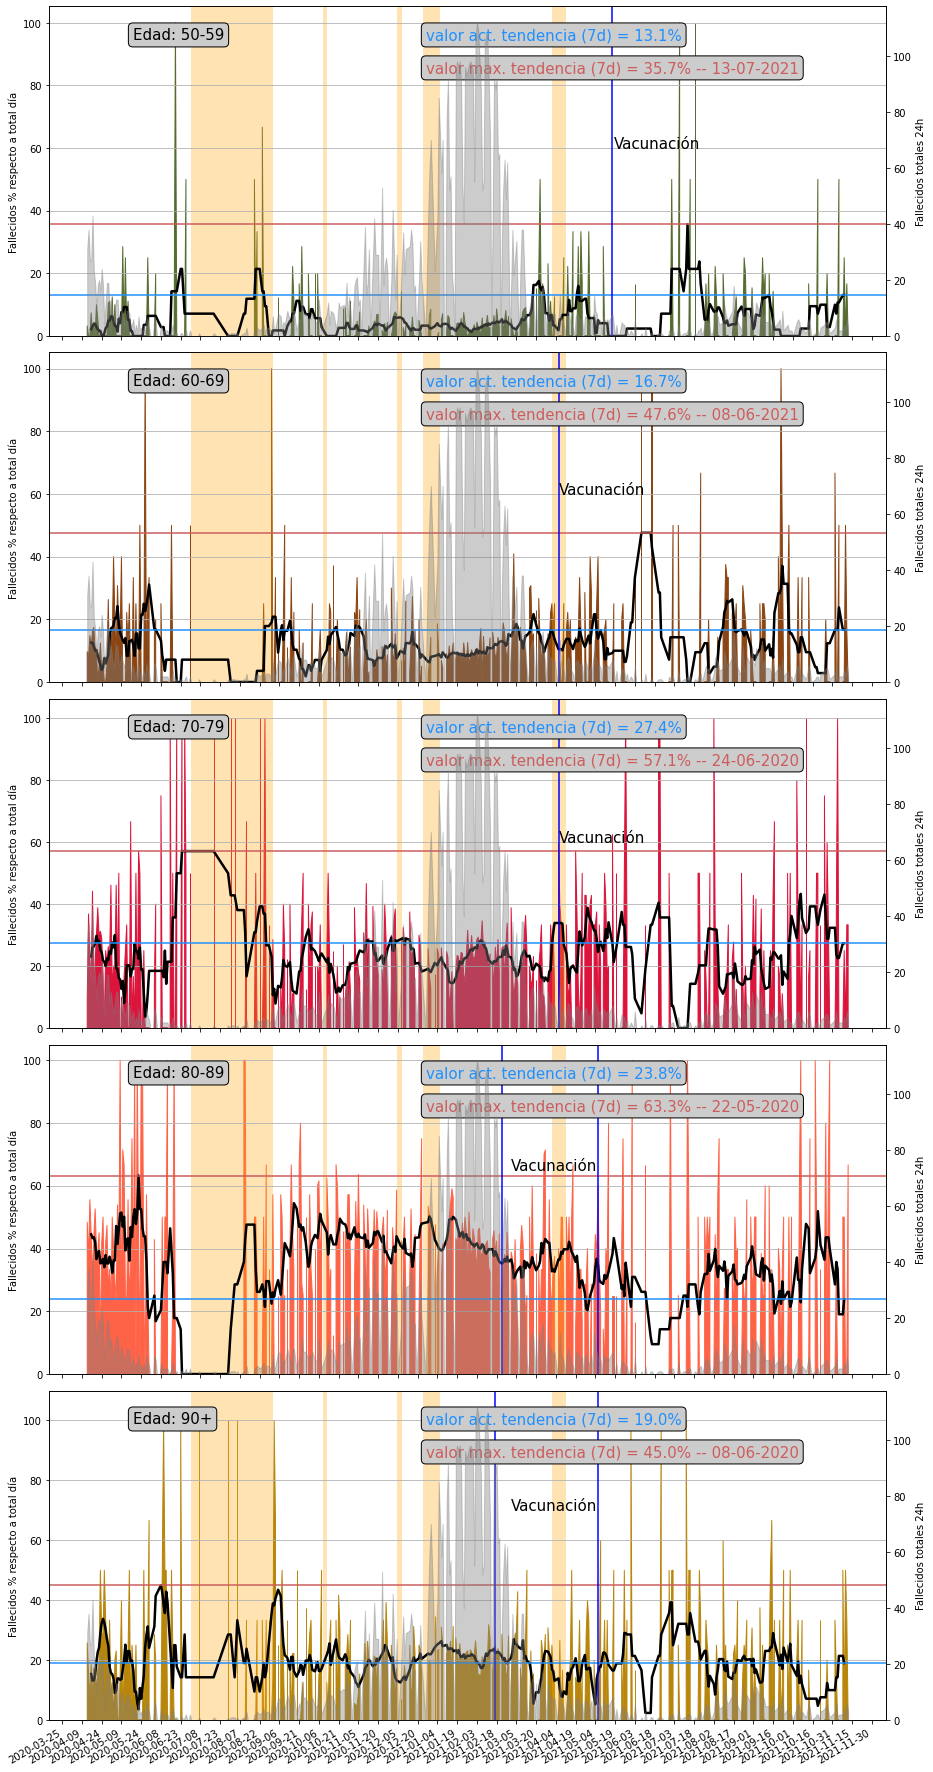

In [41]:
# Representamos el porcentaje de los fallecidos de cada franja de edad.
fig, (axs11,axs12,axs13,axs14,axs15) = plt.subplots(5,1,figsize=(15,35))
fig.subplots_adjust(hspace=0.05)

a=["50-59","60-69","70-79","80-89","90+"]

b=["Edad: 50-59","Edad: 60-69","Edad: 70-79","Edad: 80-89","Edad: 90+"]

color_val=["darkolivegreen","saddlebrown","crimson","tomato","darkgoldenrod"]

axes1=[axs11,axs12,axs13,axs14,axs15]

# Parámetros que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

# Copiamos los datos en una tabla nueva para poder calcular luego la tendencia de los datos
temp2=por_fallecidos_24h_edad.copy()
temp2=temp2.dropna(how='any',axis=0)


for i in list(range(5)):
    axes1[i].stackplot(por_fallecidos_24h_edad.index,por_fallecidos_24h_edad[a[i]],color=color_val[i])
    
    # Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
    decompose = seasonal_decompose(temp2[a[i]],period=7)
    # Representamos el resultado sobre los datos
    axes1[i].plot(decompose.trend.index, decompose.trend, c='black',linewidth=2.5)
    
    # Linea horizontal con el último valor calculado de la tendencia de los datos
    axes1[i].axhline(y=decompose.trend.iloc[-4],color="dodgerblue")
    axes1[i].axhline(y=float(decompose.trend.iloc[:].dropna().max()),color="indianred")   

    # Sombreamos las epocas de vacaciones
    axes1[i].axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
    axes1[i].axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

    # Titulo y configuración de los ehes
    axes1[i].set_ylabel('Fallecidos % respecto a total día')
    axes1[i].yaxis.grid()
    starty, endy = axes1[i].get_ylim()
    axes1[i].set_ylim((0,endy))
    
    # Texto en el que indicamos que estamos representando en cada figura
    axes1[i].annotate(b[i],xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,bbox=bbox_args)
    axes1[i].annotate('valor act. tendencia (7d) = {:.3}%'.format(decompose.trend.iloc[-4]),xy=(0.45, 0.9)
                      , xycoords='axes fraction',fontsize=15,color="dodgerblue",bbox=bbox_args)
    axes1[i].annotate("valor max. tendencia (7d) = {:.3}% -- {}".format(decompose.trend.iloc[:].dropna().max(),
                                                                   decompose.trend.idxmax(axis=0).strftime('%d-%m-%Y'))
                      ,xy=(0.45, 0.8), xycoords='axes fraction',fontsize=15,color="indianred",bbox=bbox_args)

# Configuración del eje X de la última figura
fig.autofmt_xdate()
axs15.xaxis.set_major_locator(mdates.DayLocator(interval=15))

axs15.axvline(x="2021-02-17", ymin=0, ymax=1,color="blue")
axs15.axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs15.text("2021-03-01",70,"Vacunación",fontsize=15)

axs14.axvline(x="2021-02-22", ymin=0, ymax=1,color="blue")
axs14.axvline(x="2021-05-06", ymin=0, ymax=1,color="blue")
axs14.text("2021-03-01",65,"Vacunación",fontsize=15)

axs13.axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs13.text("2021-04-06",60,"Vacunación",fontsize=15)

axs12.axvline(x="2021-04-06", ymin=0, ymax=1,color="blue")
axs12.text("2021-04-06",60,"Vacunación",fontsize=15)

axs11.axvline(x="2021-05-17", ymin=0, ymax=1,color="blue")
axs11.text("2021-05-18",60,"Vacunación",fontsize=15)

axs21=axs11.twinx() 
axs22=axs12.twinx()
axs23=axs13.twinx()
axs24=axs14.twinx()
axs25=axs15.twinx()

axes2=[axs21,axs22,axs23,axs24,axs25]

for i in list(range(5)):
    axes2[i].stackplot(temp.index,temp["fallecidos_24h"],color="grey",alpha=0.4)
    starty, endy = axes2[i].get_ylim()
    axes2[i].set_ylim((0,endy))
    axes2[i].set_ylabel('Fallecidos totales 24h')
    axes2[i].xaxis.set_major_locator(mdates.DayLocator(interval=15))

In [42]:
# range_por_casos24h=por_casos_24h_edad.copy()
# range_por_casos24h=range_por_casos24h["2021-05-01":]

# fig, ax = plt.subplots(figsize=(20,10))
# a=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]

# b=["dimgray","darkred","chocolate","slategray","greenyellow","teal","darkgreen","lightseagreen","violet"
#    ,"darkviolet"]

# for i in list(range(10)):
#     ax.plot(range_por_casos24h.index,range_por_casos24h[a[i]],color=b[i],label=a[i],linewidth=2)
# ax.legend(ncol=3,fontsize=18)

# # Dibujamos sombreado los periodos de vacaciones
# # plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# # Linea comiendo-fin vacunacion
# # ax.axvline(x="2021-02-17", ymin=0, ymax=1,color="darkviolet") # Edad 90+
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="darkviolet",linestyle="--")
# ax.text("2021-05-07",30,"fin 90+",fontsize=15,color="darkviolet")

# # ax.axvline(x="2021-02-22", ymin=0, ymax=1,color="violet") # Edad 80-89
# ax.axvline(x="2021-05-06", ymin=0, ymax=1,color="violet",linestyle="--")
# ax.text("2021-05-07",25,"fin 80-89",fontsize=15,color="violet")

# # ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="lightseagreen") # Edad 70-79
# # ax.text("2021-04-07",25," inicio 70-79",fontsize=15,color="lightseagreen")

# # ax.axvline(x="2021-04-06", ymin=0, ymax=1,color="darkgreen") # Edad 60-69
# # ax.text("2021-04-07",20,"inicio 60-69",fontsize=15,color="darkgreen")

# ax.axvline(x="2021-05-17", ymin=0, ymax=1,color="teal") # Edad 50-59
# ax.text("2021-05-18",25,"inicio 50-59",fontsize=15,color="teal")

# ax.axvline(x="2021-06-07", ymin=0, ymax=1,color="greenyellow") # Edad 40-49
# ax.text("2021-06-08",25,"inicio 40-49",fontsize=15,color="greenyellow")



# # Ponemos etiquetas y configuramos los ejes
# ax.set_title('Casos 24 h (%) - rango de edad')
# ax.set_ylabel('Casos 24h (%)')
# ax.set_xlabel('Fecha')

# ax.set_ylim((0,35))
# starty, endy = ax.get_ylim()
# ax.yaxis.set_ticks(np.arange(starty, endy, 5))
# ax.yaxis.grid()
# fig.autofmt_xdate()
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

In [43]:
print("finish")

finish
